# Import library

In [ ]:
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import datetime as dt
import numpy as np

from wordcloud import WordCloud
from geopy.distance import geodesic
import folium
from IPython.display import display

# ARIMA, SARIMA
from statsmodels.tsa.arima.model import ARIMA

#ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#scikitlearn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, f1_score 

from itertools import product

#LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
'''from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras_tuner import HyperParameters, RandomSearch'''
# Prophet
from prophet.diagnostics import cross_validation, performance_metrics

from statsmodels.tsa.arima.model import ARIMA

In [8]:
hub = pd.read_csv(r"D:\Competitions\BI8\hubs_enriched_ver2.csv")
shipper = pd.read_csv(r"D:\Competitions\BI8\shipper_enriched.csv")
calendar = pd.read_csv(r"D:\Competitions\BI8\ryo_calendar.csv")
om = pd.read_csv(r"D:\Competitions\BI8\om.csv")
lm = pd.read_csv(r"D:\Competitions\BI8\lm.csv")

C:\Users\PC\AppData\Local\Temp\ipykernel_3452\3978324134.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  om = pd.read_csv(r"D:\Competitions\BI8\om.csv")


In [9]:
data = {
    "Trọng lượng (kg)": [
        "≤ 0.5", "≤ 2", "≤ 3", "≤ 4", "≤ 5", "≤ 7", "≤ 10",
        "≤ 11", "≤ 12", "≤ 13", "≤ 14", "≤ 15", "≤ 16", "≤ 17",
        "≤ 18", "≤ 19", "≤ 20", "Mỗi 1kg tiếp theo đến 30kg",
        "Mỗi 1kg tiếp theo đến 50kg", "Trên 50kg"
    ],
    "Nội thành / Intracity (1)": [
        15000, 16000, 22000, 22000, 22000, 33000, 43000,
        50000, 55000, 60000, 65000, 70000, 75000, 80000,
        85000, 90000, 95000, 4000, 3000, 2500
    ],
    "Nội vùng / Intrazone (3)": [
        15000, 16000, 22000, 22000, 22000, 34000, 45000,
        70000, 75000, 80000, 85000, 90000, 95000, 100000,
        105000, 110000, 115000, 6000, 4500, 3500
    ],
    "Liên thành / Intercity (2)": [
        15000, 16000, 32000, 35000, 38000, 43000, 63000,
        95000, 105000, 115000, 125000, 135000, 145000, 155000,
        165000, 175000, 185000, 8000, 6500, 5000
    ],
    "Liên vùng / Interzone (4)": [
        15000, 16000, 32000, 35000, 38000, 53000, 65000,
        110000, 120000, 130000, 140000, 150000, 160000, 170000,
        180000, 190000, 200000, 10000, 8500, 7000
    ]
}


price = pd.DataFrame(data)
# pricing = price.melt(id_vars=["Weight (kg)"], var_name="delivery", value_name="price")

# Clean

In [ ]:
cols = ['dest_hub_datetime', 'pickup_datetime', 'first_valid_delivery_attempt_datetime']
for col in cols:
    lm[col] = pd.to_datetime(lm[col], errors='coerce')


cols = ['creation_datetime', 'pickup_datetime', 'delivery_success_datetime', 'rts_trigger_datetime', 'first_valid_delivery_attempt_datetime',
       'second_valid_delivery_attempt_datetime', 'third_valid_delivery_attempt_datetime', 'last_valid_delivery_attempt_datetime']
for col in cols:
    om[col] = pd.to_datetime(om[col], errors='coerce')

    
cols = ['pickup_hub_id', 'pickup_driver_id', 'delivery_driver_id']
for col in cols:
    om[col] = om[col].astype('Int64')


    
cols = ['date', 'next_working_day_0', 'next_working_day_1', 'next_working_day_2', 'next_working_day_3', 'next_working_day_4', 'next_working_day_5']
for col in cols:
    calendar[col] = pd.to_datetime(calendar[col], errors='coerce')


om = om.drop(columns=['row_num'])
om = om.drop_duplicates()



om['delivery_time'] = om['delivery_success_datetime'] - om['pickup_datetime']
om = om[om['delivery_time']>= pd.Timedelta(0)]
om = om[om['delivery_success_datetime'].dt.year !=2023]
om = om[om['weight'] <= 130000]

In [55]:
weight1 = om['weight'].sort_values(ascending=False).head(19)
weight1  # drop 19 dòng, 44 giá trị trên 1k kg, 50 giá trị trên 500kg, 61 giá trị trên 200kg, 90 giá trị trên 100kg

191630   130000.00
25421     14700.00
52624     14100.00
132200    12000.00
35430      7800.00
17422      6860.00
85234      6850.00
76914      6700.00
102687     5800.00
432966     5700.00
430144     5400.00
221785     5400.00
212335     5320.00
462217     5000.00
424356     4500.00
464094     3900.00
20026      3860.00
45081      3450.00
73847      3000.00
Name: weight, dtype: float64

## Process cột weight

In [ ]:
def extract_item_info(item_str):
    if pd.isna(item_str):
        return pd.Series([None, None])
    try:
        item_list = json.loads(item_str.replace("'", '"'))
        # Ghép tên và số lượng lại thành chuỗi cách nhau bằng dấu phẩy nếu có nhiều item
        names = ', '.join([item.get('item_name') or item.get('item_description') for item in item_list])
        quantities = ', '.join([str(item.get('item_quantity') or item.get('quantity')) for item in item_list])
        return pd.Series([names, quantities])
    except Exception as e:
        return pd.Series([None, None])

merged_df = om.copy()
merged_df[['item_name', 'item_quantity']] = merged_df['items'].apply(extract_item_info)
merged_df.drop(columns = 'items', inplace=True)

**drop các cột không có thông tin**

In [36]:
# xét > 5000kg
# merged_df[merged_df['weight']>=5000][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 1000 - 5000kg
# merged_df[(merged_df['weight']>=1000) & (merged_df['weight']<5000)][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 500 - 1000kg
# merged_df[(merged_df['weight']>=500) & (merged_df['weight']<1000)][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 200 - 500 kg
# merged_df[(merged_df['weight']>=200) & (merged_df['weight']<500)][['order_id', 'weight', 'item_name', 'item_quantity']]

#xét 100 - 200kg
merged_df[(merged_df['weight']>=100) & (merged_df['weight']<200)][['order_id', 'weight', 'item_name', 'item_quantity']]

order_id  weight  \
1641    214680441  150.30   
13360   215320782  100.00   
15232   214266092  100.00   
17617   214812190  100.00   
42964   217173156  100.00   
85503   221422672  100.40   
97522   224021822  197.76   
138799  228151322  120.00   
145410  226533083  120.00   
189419  228150399  121.00   
189686  226780728  130.67   
220926  235450156  105.62   
236305  232155223  112.00   
236462  232814640  180.00   
249150  238573866  100.33   
282680  241853531  100.00   
286890  240386444  190.00   
288985  241623545  190.00   
321203  246303737  112.67   
324736  245484449  104.12   
327516  246492841  146.67   
336462  245288349  119.00   
336519  244082391  111.72   
336872  244686513  108.55   
365563  250421774  101.23   
401553  252165020  112.06   
406764  256059829  174.59   
443378  254013132  121.12   
468679  259187580  100.00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                item_name  \
1641                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 None   
13360   Áo Thun tay Lỡ Form Rộng 3610 - Ao Phông Form Rộng Chất Cotton Chất Mịn Thấm Hút Mồ Hôi Siêu Mát, Áo Cổ Bẻ Họa Tiết Thân Trơn Kẻ Cổ - Thời Trangg Unisex Chất Liệu Thấm Hút Mồ Hôi, Áo Polo Họa Tiết Cổ Bẻ - Áo Thun Cổ Bẻ Siêu Chất 2022, Áo Polo Họa Tiết Cổ Bẻ - Áo Thun Cổ Bẻ Siêu Đẹp 2022, Áo PoLo Họa Tiết Hổ Nhỏ - Áo Thun Cổ Bẻ Thời Trang Chất 2022, Áo Thun Nam Tay Lỡ Form Rộng - Áo Phông Nam Cổ Tròn Thời trang Unisex AT007, Ao Bomber NY Bóng Chày - Áo Khoác Thân Nỉ Tay Da Cho Nam Nữ, Áo Phông Nam - Áo Thun Nam Unisex Form Rộng Chất Cotton 100%  In Mặt Người, Áo Polo Unisex Tay Lỡ Form Rộng - Áo Thun Cổ Bẻ GUCCI Nam Màu Đen Trắng AT04, Áo Thun Nam Thời Trang Unisex - Áo Phong Form Rộng Phong Cách Hàn Quốc AT008, Áo Thun Nam Cổ Tròn From Rộng Vải Cotton Co Giãn Dày Dặn Phông Trơn Tay Ngắn 004   
15232                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
# drop bỏ các đơn này do weight > 100 và không có thông tin gì về đơn hàng để xác định weight hợp lý hay không
drop_order_id = [213588865, 219127047, 217613276, 219315697, 219433968, 218013002, 221189168, 225320551, 222247080, 227961559, 234718606, 233640785, 237102891,
                 215258452, 215600293, 218460399, 219894743, 219127070, 219619143, 219315716, 219619192, 218347190, 218347213, 218351258, 217752779, 222270680, 222646768, 222203708, 226095358,
                 233640792,
                 215816352, 226095361, 232220755,
                 224021822, 228151322, 226533083, 228150399, 240386444, 246303737,
                 248069873]
om_cleaned = om[~om['order_id'].isin(drop_order_id)].copy()

**chỉnh các cột có giá trị weight đang được assume là gram**

In [39]:
merged_df = merged_df[~merged_df['order_id'].isin(drop_order_id)]

In [40]:
# xét > 5000kg
# merged_df[merged_df['weight']>=5000][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 1000 - 5000kg
# merged_df[(merged_df['weight']>=1000) & (merged_df['weight']<5000)][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 500 - 1000kg
# merged_df[(merged_df['weight']>=500) & (merged_df['weight']<1000)][['order_id', 'weight', 'item_name', 'item_quantity']]

# xét 200 - 500 kg
# merged_df[(merged_df['weight']>=200) & (merged_df['weight']<500)][['order_id', 'weight', 'item_name', 'item_quantity']]

#xét 100 - 200kg
merged_df[(merged_df['weight']>=100) & (merged_df['weight']<200)][['order_id', 'weight', 'item_name', 'item_quantity']]

order_id  weight  \
1641    214680441  150.30   
13360   215320782  100.00   
15232   214266092  100.00   
17617   214812190  100.00   
42964   217173156  100.00   
85503   221422672  100.40   
189686  226780728  130.67   
220926  235450156  105.62   
236305  232155223  112.00   
236462  232814640  180.00   
249150  238573866  100.33   
282680  241853531  100.00   
288985  241623545  190.00   
324736  245484449  104.12   
327516  246492841  146.67   
336462  245288349  119.00   
336519  244082391  111.72   
336872  244686513  108.55   
365563  250421774  101.23   
401553  252165020  112.06   
406764  256059829  174.59   
443378  254013132  121.12   
468679  259187580  100.00   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                item_name  \
1641                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 None   
13360   Áo Thun tay Lỡ Form Rộng 3610 - Ao Phông Form Rộng Chất Cotton Chất Mịn Thấm Hút Mồ Hôi Siêu Mát, Áo Cổ Bẻ Họa Tiết Thân Trơn Kẻ Cổ - Thời Trangg Unisex Chất Liệu Thấm Hút Mồ Hôi, Áo Polo Họa Tiết Cổ Bẻ - Áo Thun Cổ Bẻ Siêu Chất 2022, Áo Polo Họa Tiết Cổ Bẻ - Áo Thun Cổ Bẻ Siêu Đẹp 2022, Áo PoLo Họa Tiết Hổ Nhỏ - Áo Thun Cổ Bẻ Thời Trang Chất 2022, Áo Thun Nam Tay Lỡ Form Rộng - Áo Phông Nam Cổ Tròn Thời trang Unisex AT007, Ao Bomber NY Bóng Chày - Áo Khoác Thân Nỉ Tay Da Cho Nam Nữ, Áo Phông Nam - Áo Thun Nam Unisex Form Rộng Chất Cotton 100%  In Mặt Người, Áo Polo Unisex Tay Lỡ Form Rộng - Áo Thun Cổ Bẻ GUCCI Nam Màu Đen Trắng AT04, Áo Thun Nam Thời Trang Unisex - Áo Phong Form Rộng Phong Cách Hàn Quốc AT008, Áo Thun Nam Cổ Tròn From Rộng Vải Cotton Co Giãn Dày Dặn Phông Trơn Tay Ngắn 004   
15232                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                None   
17617                                                       

In [ ]:
# lùi dấu (,) sang trái 3 số
order_id_3 = [255072124, 252025786, 258658295,
              231702894, 242065771, 255073391, 254926690, 255212739, 254606186, 256545149, 256544013, 256545202, 259077032,
              219613062, 250396789, 254991173, 247752366,
              220382672, 236525222, 247828515, 256564595,
              214680441, 221422672, 241623545, 246492841, 259187580, 261056975,256059829 ]

# lùi dấu (,) sang trái 2 số
order_id_2 = [223855339, 221335580, 244806230, 244089558, 253748868, 217173156, 241853531, 245288349, 244082391, 244686513, 250421774]

# lùi dấu (,) sang trái 1 số
order_id_1 = [235450156, 232155223, 232814640, 245484449, 252165020 ]



def adjust_weight(row):
    if row['order_id'] in order_id_3:
        return row['weight'] / 1000
    elif row['order_id'] in order_id_2:
        return row['weight'] / 100
    elif row['order_id'] in order_id_1:
        return row['weight'] / 10
    else:
        return row['weight']

merged_df['adjusted_weight'] = merged_df.apply(adjust_weight, axis=1)

In [43]:
merged_df['adjusted_weight'].describe()

count   494261.00
mean         1.64
std          3.63
min          0.00
25%          0.40
50%          0.50
75%          1.20
max        130.67
Name: adjusted_weight, dtype: float64

In [56]:
om_cleaned = om_cleaned[om_cleaned['order_id'].isin(merged_df['order_id'])]
df_unique = merged_df.groupby('order_id').agg({
    'item_name': 'first',         # Hoặc sử dụng ' '.join nếu muốn nối các item_name
    'adjusted_weight': 'mean'
}).reset_index()
weight_map = df_unique.set_index('order_id')['adjusted_weight']

om_cleaned['weight'] = om_cleaned['order_id'].map(weight_map)
om_cleaned['weight'].describe()

count   494261.00
mean         1.64
std          3.63
min          0.00
25%          0.40
50%          0.50
75%          1.20
max        130.67
Name: weight, dtype: float64

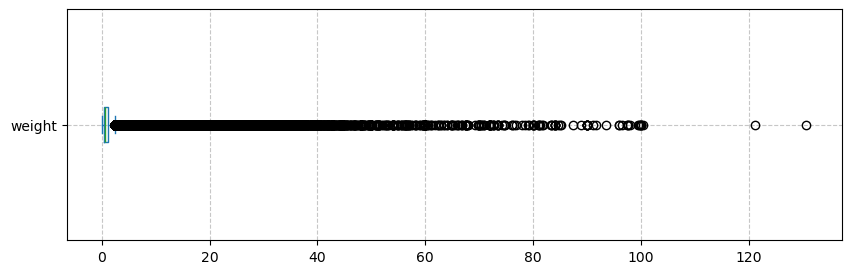

In [57]:
plt.figure(figsize=(10, 3))
om_cleaned['weight'].plot(kind='box', vert=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### WordCloud

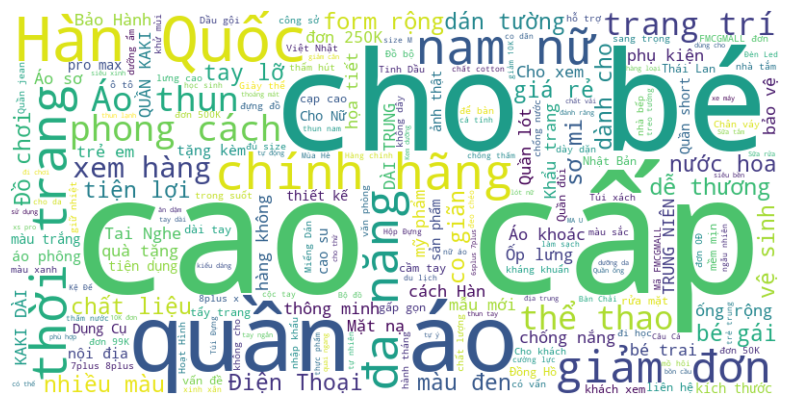

In [54]:
word_weight = merged_df[merged_df['weight'] < 10]
text = ' '.join(word_weight['item_name'].dropna().astype(str).tolist())
wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()

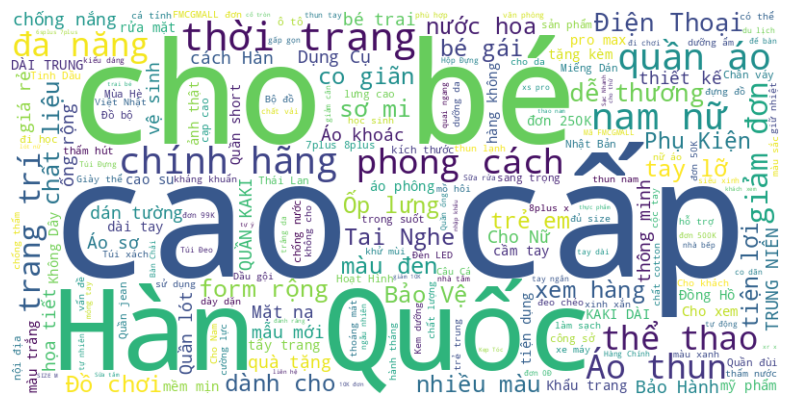

In [ ]:
word_parcel = merged_df[merged_df['parcel_size'].isin(['s', 'xs'])]
text = ' '.join(word_parcel['item_name'].dropna().astype(str).tolist())
wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

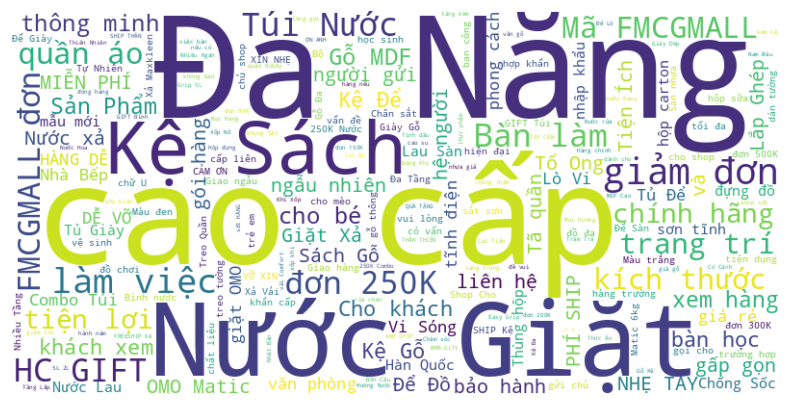

In [ ]:
word_weight = merged_df[merged_df['weight'] >10]
text = ' '.join(word_weight['item_name'].dropna().astype(str).tolist())
wordcloud3 = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()

## Tính giá

Bảng giá. reference [Bảng giá hàng nặng](https://www.kiotviet.vn/bang-gia-cac-hang-van-chuyen/)

In [ ]:
data = {
    "Weight (kg)": [
        "≤ 0.5", "≤ 2", "≤ 3", "≤ 4", "≤ 5", "≤ 7", "≤ 10",
        "≤ 11", "≤ 12", "≤ 13", "≤ 14", "≤ 15", "≤ 16", "≤ 17",
        "≤ 18", "≤ 19", "≤ 20", "Mỗi 1kg tiếp theo đến 30kg",
        "Mỗi 1kg tiếp theo đến 50kg", "Trên 50kg"
    ],
    "Intracity (1)": [
        15000, 16000, 22000, 22000, 22000, 33000, 43000,
        50000, 55000, 60000, 65000, 70000, 75000, 80000,
        85000, 90000, 95000, 4000, 3000, 2500
    ],
    "Intrazone (3)": [
        15000, 16000, 22000, 22000, 22000, 34000, 45000,
        70000, 75000, 80000, 85000, 90000, 95000, 100000,
        105000, 110000, 115000, 6000, 4500, 3500
    ],
    "Intercity (2)": [
        15000, 16000, 32000, 35000, 38000, 43000, 63000,
        95000, 105000, 115000, 125000, 135000, 145000, 155000,
        165000, 175000, 185000, 8000, 6500, 5000
    ],
    "Interzone (4)": [
        15000, 16000, 32000, 35000, 38000, 53000, 65000,
        110000, 120000, 130000, 140000, 150000, 160000, 170000,
        180000, 190000, 200000, 10000, 8500, 7000
    ]
}


price = pd.DataFrame(data)
pricing = price.melt(id_vars=["Weight (kg)"], var_name="delivery_type", value_name="price")

In [ ]:
om_cleaned = pd.merge(
    om_cleaned,
    hub[['hub_id', 'short_name', 'region']],
    left_on='pickup_hub_id',
    right_on='hub_id',
    how='left'
)

om_cleaned.rename(columns={'short_name': 'pu_province', 'region': 'pu_region'}, inplace=True)



om_cleaned = pd.merge(
    om_cleaned,
    hub[['hub_id', 'short_name', 'region']],
    left_on='delivery_success_hub_id',
    right_on='hub_id',
    how='left',
    suffixes=('', '_deli')
)

om_cleaned.rename(columns={'short_name': 'deli_province', 'region': 'deli_region'}, inplace=True)


om_cleaned = om_cleaned.drop(columns=['hub_id', 'hub_id_deli'])


replacement_mapping = {'HN': 'North', 'HCM': 'South'}
om_cleaned['pu_region'] = om_cleaned['pu_region'].replace(replacement_mapping)
om_cleaned['deli_region'] = om_cleaned['deli_region'].replace(replacement_mapping)

In [ ]:
om_cleaned['pu_region'].value_counts()

pu_region
North      311581
South      182653
Central        27
Name: count, dtype: int64

In [ ]:
def assign_delivery_type(row):
    if row['pu_province'] == row['deli_province']:
        return "Intracity (1)"
    elif (row['pu_province'] in ["Hồ Chí Minh", "Hà Nội"] and row['deli_province'] in ["Hồ Chí Minh", "Hà Nội"]):
        return "Intercity (2)"
    elif row['pu_region'] == row['deli_region']:
        return "Intrazone (3)"
    elif (row['pu_region'] in ["North", "South", "Central"] and row['deli_region'] in ["North", "South", "Central"] and row['pu_region'] != row['deli_region']):
        return "Interzone (4)"
    else:
        return "OOZ"


om_cleaned['delivery_type'] = om_cleaned.apply(assign_delivery_type, axis=1)

In [ ]:
def get_price(weight, delivery_type):
    if weight <= 0.5:
        weight_bracket = '≤ 0.5'
    elif weight <= 2:
        weight_bracket = '≤ 2'
    elif weight <= 3:
        weight_bracket = '≤ 3'
    elif weight <= 4:
        weight_bracket = '≤ 4'
    elif weight <= 5:
        weight_bracket = '≤ 5'
    elif weight <= 7:
        weight_bracket = '≤ 7'
    elif weight <= 10:
        weight_bracket = '≤ 10'
    elif weight <= 20:
        weight_bracket = f'≤ {int(weight)}'

    elif weight <= 30:
        base_price_row = pricing[(pricing['Weight (kg)'] == '≤ 20') & (pricing['delivery_type'] == delivery_type)]
        base_price = base_price_row['price'].values[0] if not base_price_row.empty else 0
        additional_weight = weight - 20
        additional_price = additional_weight * pricing[(pricing['Weight (kg)'] == 'Mỗi 1kg tiếp theo đến 30kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        return base_price + additional_price

    elif weight <= 50:
        base_price_row = pricing[(pricing['Weight (kg)'] == '≤ 20') & (pricing['delivery_type'] == delivery_type)]
        base_price = base_price_row['price'].values[0] if not base_price_row.empty else 0
        additional_price_30kg = 10 * pricing[(pricing['Weight (kg)'] == 'Mỗi 1kg tiếp theo đến 30kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        additional_weight = weight - 30
        additional_price_50kg = additional_weight * pricing[(pricing['Weight (kg)'] == 'Mỗi 1kg tiếp theo đến 50kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        return base_price + additional_price_30kg + additional_price_50kg

    else:
        base_price_row = pricing[(pricing['Weight (kg)'] == '≤ 20') & (pricing['delivery_type'] == delivery_type)]
        base_price = base_price_row['price'].values[0] if not base_price_row.empty else 0
        additional_price_30kg = 10 * pricing[(pricing['Weight (kg)'] == 'Mỗi 1kg tiếp theo đến 30kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        additional_price_50kg = 20 * pricing[(pricing['Weight (kg)'] == 'Mỗi 1kg tiếp theo đến 50kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        additional_weight = weight - 50
        additional_price_over_50kg = additional_weight * pricing[(pricing['Weight (kg)'] == 'Trên 50kg') & (pricing['delivery_type'] == delivery_type)]['price'].values[0]
        return base_price + additional_price_30kg + additional_price_50kg + additional_price_over_50kg

    base_price_row = pricing[(pricing['Weight (kg)'] == weight_bracket) & (pricing['delivery_type'] == delivery_type)]
    base_price = base_price_row['price'].values[0] if not base_price_row.empty else 0

    return base_price

In [ ]:
om_cleaned['price'] = om_cleaned.apply(lambda x: get_price(x['weight'], x['delivery_type']), axis=1)

In [ ]:
om_cleaned[om_cleaned['weight']>30][['weight', 'delivery_type', 'price']]

weight  delivery_type     price
1372     30.73  Intrazone (3) 178285.00
1814     34.91  Intrazone (3) 197090.52
2966     31.22  Intrazone (3) 180490.00
4036     46.00  Interzone (4) 436000.00
5170     37.00  Intracity (1) 156000.00
...        ...            ...       ...
492320   32.34  Interzone (4) 319890.00
492994   36.60  Interzone (4) 356100.00
493151   40.79  Intrazone (3) 223555.00
493873   40.00  Interzone (4) 385000.00
494163   33.45  Intracity (1) 145350.00

[1048 rows x 3 columns]

# Bài toán nhân sự

In [ ]:
n_orders_per_day = len(om_cleaned)/364
n_orders_per_day

1357.85989010989

In [ ]:
# sau khi ký hợp đồng với một vài đối tác tiềm năng, có thể thúc đẩy tăng trưởng 71% lượng đơn hàng ngày vào đầu năm 2023.
n_orders_per_day_23 = n_orders_per_day *1.71
n_orders_per_day_23

2321.940412087912

In [ ]:
# Mỗi tài xế có thể xử lý giao trả hàng trung bình khoảng 40 đơn hàng/ngày.
total_drivers = n_orders_per_day_23/40
total_drivers

58.048510302197805

In [ ]:
om_cleaned['date'] = pd.to_datetime(om_cleaned['creation_datetime']).dt.date

# Define the specific dates for Double Days in 2022
double_days = ['2022-04-04', '2022-05-05', '2022-06-06', '2022-07-07', '2022-08-08', '2022-10-10', '2022-11-11', '2022-12-12']

# Convert the 'double_days' list to datetime objects for comparison
double_days = pd.to_datetime(double_days).date

# Filter the DataFrame to only include orders from Double Days
double_days_total_orders = len(om_cleaned[om_cleaned['date'].isin(double_days)])

# Calculate the average number of orders on Double Days
avg_n_orders_double_day = double_days_total_orders / len(double_days)

avg_n_orders_double_day

4285.0

In [ ]:
om_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494261 entries, 0 to 500001
Data columns (total 44 columns):
 #   Column                                  Non-Null Count   Dtype          
---  ------                                  --------------   -----          
 0   order_id                                494261 non-null  int64          
 1   creation_datetime                       494259 non-null  datetime64[ns] 
 2   cod_value_sgd                           404024 non-null  float64        
 3   granular_status                         494261 non-null  object         
 4   rts_flag                                494261 non-null  int64          
 5   order_type                              494261 non-null  object         
 6   shipper_id                              494261 non-null  int64          
 7   shipper_reference_number                378021 non-null  object         
 8   delivery_type                           494261 non-null  object         
 9   pickup_hub_id                  

Quy Trình Giao Hàng Của Ryo Bao Gồm 4 Trường Hợp:
* Trường Hợp 1: Giao Hàng Trong Cùng Một Tỉnh
Mô Tả: Vận chuyển hàng hóa giữa các hub cấp huyện/quận trong cùng một tỉnh.
Quy Trình: Hàng hóa được chuyển trực tiếp từ hub bắt đầu đến hub đích trong cùng tỉnh, không qua hub trung tâm.
* Trường Hợp 2: Giao Hàng Khác Tỉnh (Không Liên Quan Đến Hà Nội và TP. Hồ Chí Minh)
Mô Tả: Vận chuyển hàng hóa giữa các tỉnh, ngoại trừ Hà Nội và TP. Hồ Chí Minh.
Quy Trình: Hàng hóa được vận chuyển từ hub bắt đầu đến hub trung tâm của tỉnh bắt đầu, sau đó qua hub trung tâm của tỉnh đích và cuối cùng đến hub đích.
* Trường Hợp 3: Giao Hàng Từ Các Tỉnh Đến Hà Nội Hoặc TP. Hồ Chí Minh
Mô Tả: Vận chuyển hàng hóa từ bất kỳ tỉnh nào đến Hà Nội hoặc TP. Hồ Chí Minh.
Quy Trình: Hàng hóa được chuyển từ hub bắt đầu đến hub trung tâm của tỉnh bắt đầu, sau đó trực tiếp đến hub đích tại Hà Nội hoặc TP. Hồ Chí Minh.
* Trường Hợp 4: Giao Hàng Từ Hà Nội Hoặc TP. Hồ Chí Minh Đến Các Tỉnh Khác
Mô Tả: Vận chuyển hàng hóa từ Hà Nội hoặc TP. Hồ Chí Minh đến bất kỳ tỉnh nào khác.
Quy Trình: Hàng hóa được gửi từ hub bắt đầu tại Hà Nội hoặc TP. Hồ Chí Minh, sau đó trực tiếp đến hub trung tâm của tỉnh đích và từ đó đến hub đích.


In [ ]:
hub[hub['hub_id'].isin([1138, 62])]

hub_id             hub_name short_name   address_city facility_type  \
274      62  *****hai Binh *****  Thái Bình  TP. Thái Bình       STATION   
899    1138  *****han - NOR*****     Hà Nam     H. Lý Nhân       STATION   

    region   area  latitude  longitude    creation_datetime created_month  
274  North  metro     20.46     106.33  2017-04-12T22:19:31       2017-04  
899  North   sub1     20.54     106.06  2020-02-27T14:11:49       2020-02

In [ ]:
'''Tính toán Số lượng Đơn Hàng Dự Kiến:
Ngày Bình Thường:
Trung bình 1,500 đơn/ngày năm 2022.
Dự kiến số lượng đơn hàng = 1,500 × 1.71 = 2,565 đơn/ngày năm 2023.
Ngày Double Day:
Trung bình 4,285 đơn/ngày năm 2022.
Dự kiến số lượng đơn hàng = 4,285 × 1.71 = 7,330 đơn/ngày năm 2023.
2. Tính Toán Nhu Cầu Tài Xế
Tài xế cần cho Ngày Bình Thường:
Số đơn hàng dự kiến = 2,565 đơn/ngày.
Mỗi tài xế xử lý trung bình 40 đơn/ngày.
Số tài xế cần thiết = 2,565 / 40 ≈ 64 tài xế.
Tài xế cần cho Ngày Double Day:
Số đơn hàng dự kiến = 7,330 đơn/ngày.
Mỗi tài xế xử lý trung bình 40 đơn/ngày.
Số tài xế cần thiết = 7,330 / 40 ≈ 183 tài xế.
3. Xác Định Số Lượng Tài Xế Hiện Tại và Cần Thêm
Số lượng tài xế hiện tại: 8,715.
Tài xế cần cho Ngày Bình Thường: 64 tài xế (dưới ngưỡng hiện tại).
Tài xế cần cho Ngày Double Day: 183 tài xế (dưới ngưỡng hiện tại).'''



In [ ]:
n_orders_per_day = len(om_cleaned)/364
n_orders_per_day_23 = n_orders_per_day *1.71

om_cleaned['date'] = pd.to_datetime(om_cleaned['creation_datetime']).dt.date
double_days = ['2022-04-04', '2022-05-05', '2022-06-06', '2022-07-07', '2022-08-08', '2022-10-10', '2022-11-11', '2022-12-12']
double_days = pd.to_datetime(double_days).date
double_days_total_orders = len(om_cleaned[om_cleaned['date'].isin(double_days)])
avg_n_orders_double_day = double_days_total_orders / len(double_days)
avg_n_orders_double_day_2023 = avg_n_orders_double_day*1.71

orders_per_driver = 40

current_drivers = om_cleaned['pickup_driver_id'].nunique()

success_rate_first_attempt = 0.7742
success_rate_second_attempt = 0.5236
success_rate_third_attempt = 0.3272
success_rate_last_attempt = 0.1092

# Tính toán số đơn hàng thành công cho Ngày Bình Thường
orders_first_attempt_success1 = n_orders_per_day_23 * success_rate_first_attempt
orders_second_attempt1 = n_orders_per_day_23 - orders_first_attempt_success1
orders_second_attempt_success1 = orders_second_attempt1 * success_rate_second_attempt
orders_third_attempt1 = orders_second_attempt1 - orders_second_attempt_success1
orders_third_attempt_success1 = orders_third_attempt1 * success_rate_third_attempt
orders_last_attempt1 = orders_third_attempt1 - orders_third_attempt_success1
orders_last_attempt_success1 = orders_last_attempt1 * success_rate_last_attempt

total_successful_orders1 = (orders_first_attempt_success1 +
                           orders_second_attempt_success1 +
                           orders_third_attempt_success1 +
                           orders_last_attempt_success1)
drivers_needed_2023 = total_successful_orders1 / orders_per_driver

# Tính toán số đơn hàng thành công cho Ngày Double Day
orders_first_attempt_success2 = avg_n_orders_double_day_2023 * success_rate_first_attempt
orders_second_attempt2 = avg_n_orders_double_day_2023 - orders_first_attempt_success2
orders_second_attempt_success2 = orders_second_attempt2 * success_rate_second_attempt
orders_third_attempt2 = orders_second_attempt2 - orders_second_attempt_success2
orders_third_attempt_success2 = orders_third_attempt2 * success_rate_third_attempt
orders_last_attempt2 = orders_third_attempt2 - orders_third_attempt_success2
orders_last_attempt_success2 = orders_last_attempt2 * success_rate_last_attempt

total_successful_orders2 = (orders_first_attempt_success2 +
                           orders_second_attempt_success2 +
                           orders_third_attempt_success2 +
                           orders_last_attempt_success2)
drivers_needed_2023_double_day = total_successful_orders2 / orders_per_driver

print(f"Số đơn hàng trung bình mỗi ngày năm 2022: {n_orders_per_day:.2f} đơn/ngày")
print(f"Số đơn hàng dự kiến mỗi ngày năm 2023: {n_orders_per_day_23:.2f} đơn/ngày")
print(f"Số đơn hàng trung bình trong ngày Double Day năm 2022: {avg_n_orders_double_day:.2f} đơn/ngày")
print(f"Số đơn hàng dự kiến trong ngày Double Day năm 2023: {avg_n_orders_double_day_2023:.2f} đơn/ngày")
print(f"Số tài xế hiện tại: {current_drivers}")
print(f"Số tài xế cần thiết ngày thường: {drivers_needed_2023}")
print(f"Số tài xế cần thiết cho ngày double day: {drivers_needed_2023_double_day}")

Số đơn hàng trung bình mỗi ngày năm 2022: 1357.86 đơn/ngày
Số đơn hàng dự kiến mỗi ngày năm 2023: 2321.94 đơn/ngày
Số đơn hàng trung bình trong ngày Double Day năm 2022: 4285.00 đơn/ngày
Số đơn hàng dự kiến trong ngày Double Day năm 2023: 7327.35 đơn/ngày
Số tài xế hiện tại: 6002
Số tài xế cần thiết ngày thường: 54.3060865530213
Số tài xế cần thiết cho ngày double day: 171.37377911712522


In [ ]:
double_days = ['2022-04-04', '2022-05-05', '2022-06-06', '2022-07-07', '2022-08-08', '2022-10-10', '2022-11-11', '2022-12-12']
double_days = pd.to_datetime(double_days).date

# Phân loại ngày (Ngày thường và Double Day)
om_cleaned['date'] = pd.to_datetime(om_cleaned['creation_datetime']).dt.date
om_cleaned['is_double_day'] = om_cleaned['date'].isin(double_days)

# Kết hợp pickup_hub_id và delivery_success_hub_id, hợp nhất để tạo ra danh sách tất cả hub
om_cleaned['hub_id'] = om_cleaned.apply(lambda x: x['pickup_hub_id'] if pd.notna(x['pickup_hub_id']) else x['delivery_success_hub_id'], axis=1)

In [ ]:
merged_pickup_hub = om_cleaned.merge(hub, left_on='pickup_hub_id', right_on='hub_id', how='left', suffixes=('', '_pickup'))

merged_hub = merged_pickup_hub.merge(hub, left_on='delivery_success_hub_id', right_on='hub_id', how='left', suffixes=('', '_delivery'))

In [ ]:
hub[(hub['facility_type'] == 'CROSSDOCK') & (hub['hub_id'].isin([12,15]))]

hub_id             hub_name   short_name  address_city facility_type  \
423      12  *****Binh Tan *****  Hồ Chí Minh   Q. Bình Tân     CROSSDOCK   
739      15  *****ong Bien *****       Hà Nội  Q. Long Biên     CROSSDOCK   

    region   area  latitude  longitude    creation_datetime created_month  
423    HCM  metro     10.77     106.58  2016-04-15T09:58:07       2016-04  
739     HN  metro     21.03     105.92  2016-07-19T19:27:40       2016-07

In [ ]:
merged_hub[(merged_hub['facility_type'] == 'CROSSDOCK') & (merged_hub['hub_id'].isin([12,15]))]

order_id   creation_datetime  cod_value_sgd     granular_status  \
5       196732481 2022-01-03 08:23:23            NaN           Completed   
9       201086995 2022-01-17 21:22:49           3.67           Completed   
10      203402435 2022-01-28 17:02:01           8.28           Completed   
15      202939821 2022-01-24 20:52:20            NaN           Completed   
37      199926788 2022-01-14 14:17:57          11.65           Completed   
...           ...                 ...            ...                 ...   
494221  257235875 2022-12-06 13:07:28          19.33           Completed   
494228  258544488 2022-12-13 15:03:35          13.51           Completed   
494242  259246635 2022-12-17 22:44:20          19.63           Completed   
494251  256998651 2022-12-05 02:08:24          11.41  Returned to Sender   
494255  257878679 2022-12-11 12:45:42           2.69           Completed   

        rts_flag order_type  shipper_id shipper_reference_number  \
5              0     Normal     5236737           NTKMP471748629   
9              0     Normal      372455          334991541610436   
10             0     Normal      547394          335305213674082   
15             0     Normal      372455          335923513988980   
37             0     Normal     5820919           S2670476O42131   
...          ...        ...         ...                      ...   
494221         0     Normal      372455          384688561196788   
494228         0     Normal      341167          386777798142657   
494242         0     Normal     6688748          VN229942565174B   
494251         1     Normal      372455          382470262367864   
494255         0     Normal      372455          385402706360436   

           delivery_type  pickup_hub_id  ...    hub_name_delivery  \
5       3 Days - Anytime             15  ...  *****Nghe An -*****   
9       3 Days - Anytime             15  ...  *****yen Quang*****   
10      3 Days - Anytime             15  ...  *****Bang - NO*****   
15      3 Days - Anytime             15  ...  *****ong - SOU*****   
37      3 Days - Anytime             15  ...  *****iang - NO*****   
...                  ...            ...  ...                  ...   
494221  3 Days - Anytime             15  ...  *****pa - NOR *****   
494228  3 Days - Anytime             15  ...  *****at - NOR *****   
494242  3 Days - Anytime             15  ...  *****ong Thap *****   
494251  3 Days - Anytime             15  ...  *****XB - Pick*****   
494255  3 Days - Anytime             12  ...  *****Lam - SOU*****   

        short_name_delivery  address_city_delivery facility_type_delivery  \
5                   Nghệ An               TP. Vinh                STATION   
9               Tuyên Quang        TP. Tuyên Quang                STATION   
10                   Hà Nam            H. Kim Bảng                STATION   
15               Tiền Giang            TX. Gò Công                STATION   
37                Hải Dương          H. Ninh Giang                STATION   
...                     ...                    ...                    ...   
494221              Lào Cai              TX. Sa Pa                STATION   
494228               Hà Nội          H. Thạch Thất                STATION   
494242            Đồng Tháp           TP. Cao Lãnh                STATION   
494251          Hồ Chí Minh            Q. Bình Tân                 OTHERS   
494255             Lâm Đồng             H. Bảo Lâm                STATION   

       region_delivery area_delivery latitude_delivery  longitude_delivery  \
5                North         metro             18.68              105.66   
9                North         metro             21.81              105.22   
10               North          sub1             20.59              105.86   
15               South          sub2             10.36              106.69   
37               North          sub1             20.72              106.32   
...                ...           ...               ...   

In [ ]:
crossdock = merged_hub[merged_hub['facility_type'] == 'CROSSDOCK']

In [ ]:
# Tính số lượng đơn hàng trung bình mỗi ngày cho cả pickup và delivery hub
orders_per_pickup_normal = om_cleaned[~om_cleaned['is_double_day']].groupby('pickup_hub_id').size() / 354  
orders_per_delivery_normal = om_cleaned[~om_cleaned['is_double_day']].groupby('delivery_success_hub_id').size() / 354  
orders_per_hub_normal = orders_per_pickup_normal.add(orders_per_delivery_normal, fill_value=0) 

orders_per_pickup_double_day = om_cleaned[om_cleaned['is_double_day']].groupby('pickup_hub_id').size() / len(double_days)  
orders_per_delivery_double_day = om_cleaned[om_cleaned['is_double_day']].groupby('delivery_success_hub_id').size() / len(double_days)  
orders_per_hub_double_day = orders_per_pickup_double_day.add(orders_per_delivery_double_day, fill_value=0)  

# Tính tỷ lệ thành công lần giao đầu tiên (1st delivery success rate) cho cả ngày thường và Double Day
first_delivery_success_normal = om_cleaned[~om_cleaned['is_double_day']].groupby('hub_id').apply(lambda x: (x['first_valid_delivery_attempt_status'] == 'success').mean())
first_delivery_success_double_day = om_cleaned[om_cleaned['is_double_day']].groupby('hub_id').apply(lambda x: (x['first_valid_delivery_attempt_status'] == 'success').mean())

# Số nhân sự hiện tại của mỗi hub dựa trên thông tin tài xế (không cộng tài xế, chỉ tính cho từng loại hub)
current_drivers_per_hub = om_cleaned.groupby('hub_id')['pickup_driver_id'].nunique()

# Tính số lượng đơn hàng trung bình mỗi ngày dự kiến năm 2023 cho mỗi hub
growth_factor = 1.71
orders_per_hub_2023_normal = orders_per_hub_normal * growth_factor
orders_per_hub_2023_double_day = orders_per_hub_double_day * growth_factor



hub_breakdown = pd.DataFrame({
    'Số đơn trung bình mỗi ngày (Ngày thường)': orders_per_hub_normal,
    'Tỷ lệ thành công lần đầu (Ngày thường)': first_delivery_success_normal,
    'Số đơn trung bình mỗi ngày (Double Day)': orders_per_hub_double_day,
    'Tỷ lệ thành công lần đầu (Double Day)': first_delivery_success_double_day,
    'Số nhân sự hiện tại': current_drivers_per_hub,
    'Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)': orders_per_hub_2023_normal,
    'Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)': orders_per_hub_2023_double_day
})

hub_breakdown = hub_breakdown.reset_index().rename(columns={'index': 'hub_id'})

In [ ]:
# Tính số lượng đơn hàng trung bình mỗi ngày cho cả pickup và delivery hub
orders_per_pickup_normal = crossdock[~crossdock['is_double_day']].groupby('pickup_hub_id').size() / 354  # Ngày thường
orders_per_delivery_normal = crossdock[~crossdock['is_double_day']].groupby('delivery_success_hub_id').size() / 354  # Ngày thường
orders_per_hub_normal = orders_per_pickup_normal.add(orders_per_delivery_normal, fill_value=0)  # Cộng số đơn pickup và delivery

orders_per_pickup_double_day = crossdock[crossdock['is_double_day']].groupby('pickup_hub_id').size() / len(double_days)  # Double Day
orders_per_delivery_double_day = crossdock[crossdock['is_double_day']].groupby('delivery_success_hub_id').size() / len(double_days)  # Double Day
orders_per_hub_double_day = orders_per_pickup_double_day.add(orders_per_delivery_double_day, fill_value=0)  # Cộng số đơn pickup và delivery

# Tính tỷ lệ thành công lần giao đầu tiên (1st delivery success rate) cho cả ngày thường và Double Day
first_delivery_success_normal = crossdock[~crossdock['is_double_day']].groupby('hub_id').apply(lambda x: (x['first_valid_delivery_attempt_status'] == 'success').mean())
first_delivery_success_double_day = crossdock[crossdock['is_double_day']].groupby('hub_id').apply(lambda x: (x['first_valid_delivery_attempt_status'] == 'success').mean())

# Số nhân sự hiện tại của mỗi hub dựa trên thông tin tài xế (không cộng tài xế, chỉ tính cho từng loại hub)
current_drivers_per_hub = crossdock.groupby('hub_id')['pickup_driver_id'].nunique()

# Tính số lượng đơn hàng trung bình mỗi ngày dự kiến năm 2023 cho mỗi hub
growth_factor = 1.71
orders_per_hub_2023_normal = orders_per_hub_normal * growth_factor
orders_per_hub_2023_double_day = orders_per_hub_double_day * growth_factor

# Tạo DataFrame chứa kết quả
hub_breakdown = pd.DataFrame({
    'Số đơn trung bình mỗi ngày (Ngày thường)': orders_per_hub_normal,
    'Tỷ lệ thành công lần đầu (Ngày thường)': first_delivery_success_normal,
    'Số đơn trung bình mỗi ngày (Double Day)': orders_per_hub_double_day,
    'Tỷ lệ thành công lần đầu (Double Day)': first_delivery_success_double_day,
    'Số nhân sự hiện tại': current_drivers_per_hub,
    'Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)': orders_per_hub_2023_normal,
    'Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)': orders_per_hub_2023_double_day
})

# Reset index để có được danh sách hub trong dataframe
hub_breakdown = hub_breakdown.reset_index().rename(columns={'index': 'hub_id'})

In [ ]:
hub_breakdown

hub_id  Số đơn trung bình mỗi ngày (Ngày thường)  \
0         1                                      0.08   
1        12                                     61.14   
2        13                                      0.44   
3        15                                    153.32   
4        20                                      0.54   
..      ...                                       ...   
783  104533                                      0.54   
784  104598                                      0.11   
785  104599                                      0.04   
786  104687                                      0.39   
787  104700                                      0.24   

     Tỷ lệ thành công lần đầu (Ngày thường)  \
0                                      0.00   
1                                      0.00   
2                                       NaN   
3                                      0.00   
4                                       NaN   
..                                      ...   
783                                     NaN   
784                                     NaN   
785                                     NaN   
786                                     NaN   
787                                     NaN   

     Số đơn trung bình mỗi ngày (Double Day)  \
0                                        NaN   
1                                     148.50   
2                                       0.62   
3                                     441.25   
4                                       1.00   
..                                       ...   
783                                     1.12   
784                                      NaN   
785                                      NaN   
786                                     1.25   
787                                     0.38   

     Tỷ lệ thành công lần đầu (Double Day)  Số nhân sự hiện tại  \
0                                      NaN                 1.00   
1                                     0.00                 1.00   
2                                      NaN                  NaN   
3                                     0.00                 6.00   
4                                      NaN                  NaN   
..                                     ...                  ...   
783                                    NaN                  NaN   
784                                    NaN                  NaN   
785                                    NaN                  NaN   
786                                    NaN                  NaN   
787                                    NaN                  NaN   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)  \
0                                                     0.14   
1                                                   104.55   
2                                                     0.75   
3                                                   262.17   
4                                                     0.92   
..                                                     ...   
783                                                   0.93   
784                                                   0.18   
785                                                   0.07   
786                                                   0.66   
787                                                   0.41   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)  
0                                                     NaN  
1                                                  253.94  
2                                                    1.07  
3                                                  754.54  
4                                                    1.71  
..                                                    ...  
783                                                  1.92  
784                                                   NaN  
785                                                   NaN  
786                         

In [ ]:
driver_hub_count = om_cleaned.groupby('delivery_driver_id')['hub_id'].nunique()
drivers_multiple_hubs = driver_hub_count[driver_hub_count > 1]

# lấy thông tin chi tiết của những tài xế làm việc ở nhiều hub
drivers_multiple_hubs_info = om_cleaned[om_cleaned['delivery_driver_id'].isin(drivers_multiple_hubs.index)]
drivers_multiple_hubs_info

order_id   creation_datetime  cod_value_sgd granular_status  \
0       199157240 2022-01-11 14:53:18            NaN       Completed   
1       199928598 2022-01-14 14:23:38            NaN       Completed   
2       203317956 2022-01-27 13:58:21           0.70       Completed   
3       203040174 2022-01-25 13:27:40            NaN       Completed   
5       196732481 2022-01-03 08:23:23            NaN       Completed   
...           ...                 ...            ...             ...   
499997  260697640 2022-12-27 15:55:11            NaN       Completed   
499998  260453897 2022-12-26 12:23:26            NaN       Completed   
499999  259929584 2022-12-23 11:24:14           1.75       Completed   
500000  260579615 2022-12-27 08:20:55            NaN       Completed   
500001  260552348 2022-12-26 22:16:05            NaN       Completed   

        rts_flag order_type  shipper_id shipper_reference_number  \
0              0     Normal     6737585          VN229632633086W   
1              0     Normal     7006074                      NaN   
2              0     Normal     6073024                      NaN   
3              0     Normal     6471264          VN225315760162I   
5              0     Normal     5236737           NTKMP471748629   
...          ...        ...         ...                      ...   
499997         0     Normal     6045444   LANS695147NM.609752199   
499998         0     Normal     6313396          VN225871851357C   
499999         0     Normal     8087778         S20009550O2059U1   
500000         0     Normal     3756900          VN225999824008I   
500001         0     Normal     6187027          VN2248738259691   

             delivery_type  pickup_hub_id  ... width  height  length  \
0       3 Days - Day/Night         103322  ...  0.00    0.00    0.00   
1         3 Days - Anytime            205  ...   NaN     NaN     NaN   
2         3 Days - Anytime         103718  ...   NaN     NaN     NaN   
3       3 Days - Day/Night            199  ...  0.00    0.00    0.00   
5         3 Days - Anytime             15  ...  0.00    0.00    0.00   
...                    ...            ...  ...   ...     ...     ...   
499997  3 Days - Day/Night           1262  ...   NaN     NaN     NaN   
499998  3 Days - Day/Night           1231  ... 29.33   22.70   48.45   
499999    3 Days - Anytime            295  ...   NaN     NaN     NaN   
500000  3 Days - Day/Night            116  ...  5.00    5.00    5.00   
500001  3 Days - Day/Night            130  ... 21.99   13.00   28.07   

       parcel_size created_month total_rows_per_month   delivery_time  \
0                s       2022-01                24805 2 days 19:09:24   
1                s       2022-01                24805 1 days 00:38:33   
2                s       2022-01                24805 1 days 02:56:28   
3                s       2022-01                24805 2 days 05:48:58   
5                l       2022-01                24805 0 days 18:32:46   
...            ...           ...                  ...             ...   
499997           s       2022-12              4561952 0 days 18:38:58   
499998           m       2022-12              4561952 0 days 16:27:26   
499999          xs       2022-12              4561952 2 days 23:03:00   
500000           s       2022-12              4561952 0 days 18:30:49   
500001           m       2022-12              4561952 0 days 22:41:54   

              date is_double_day  hub_id  
0       2022-01-11         False  103322  
1       2022-01-14         False     205  
2       2022-01-27         False  103718  
3       2022-01-25         False     199  
5       2022-01-03         False      15  
...            ...           ...     ...  
499997  2022-12-27         False    1262  
499998  2022-12-26         False    1231  
499999  2022-12-23         False     295  
500000  2022-12-27         False     116  
500001  2022-12-26         False     130  

[493210 rows x 46 columns]

In [ ]:
# Create a function to calculate distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

hub_distances = []
for i, hub1 in hub.iterrows():
    for j, hub2 in hub.iterrows():
        if i < j:  
            distance = calculate_distance(hub1['latitude'], hub1['longitude'], hub2['latitude'], hub2['longitude'])
            hub_distances.append({
                'hub1_id': hub1['hub_id'],
                'hub2_id': hub2['hub_id'],
                'distance_km': distance
            })

hub_distance_df = pd.DataFrame(hub_distances)
hub_distance_df.head()

hub1_id  hub2_id  distance_km
0     1107     1104       253.25
1     1107     1111     11465.94
2     1107     1103       168.85
3     1107     1102     11465.94
4     1107     1106        48.47

In [ ]:
driver_hub_counts = om_cleaned.groupby('delivery_driver_id')['hub_id'].nunique().reset_index()
driver_hub_counts.columns = ['delivery_driver_id', 'hub_count']

drivers_multiple_hubs = driver_hub_counts[driver_hub_counts['hub_count'] > 1]
drivers_hub_details = om_cleaned[om_cleaned['delivery_driver_id'].isin(drivers_multiple_hubs['delivery_driver_id'])]
drivers_hub_details = drivers_hub_details.merge(hub[['hub_id', 'latitude', 'longitude']], on='hub_id', how='left')

order_id   creation_datetime  cod_value_sgd granular_status  rts_flag  \
0  199157240 2022-01-11 14:53:18            NaN       Completed         0   
1  199928598 2022-01-14 14:23:38            NaN       Completed         0   
2  203317956 2022-01-27 13:58:21           0.70       Completed         0   
3  203040174 2022-01-25 13:27:40            NaN       Completed         0   
4  196732481 2022-01-03 08:23:23            NaN       Completed         0   

  order_type  shipper_id shipper_reference_number       delivery_type  \
0     Normal     6737585          VN229632633086W  3 Days - Day/Night   
1     Normal     7006074                      NaN    3 Days - Anytime   
2     Normal     6073024                      NaN    3 Days - Anytime   
3     Normal     6471264          VN225315760162I  3 Days - Day/Night   
4     Normal     5236737           NTKMP471748629    3 Days - Anytime   

   pickup_hub_id  ... length  parcel_size  created_month total_rows_per_month  \
0         103322  ...   0.00            s        2022-01                24805   
1            205  ...    NaN            s        2022-01                24805   
2         103718  ...    NaN            s        2022-01                24805   
3            199  ...   0.00            s        2022-01                24805   
4             15  ...   0.00            l        2022-01                24805   

    delivery_time        date is_double_day  hub_id latitude longitude  
0 2 days 19:09:24  2022-01-11         False  103322    10.75    106.61  
1 1 days 00:38:33  2022-01-14         False     205    10.78    106.60  
2 1 days 02:56:28  2022-01-27         False  103718    14.06    109.05  
3 2 days 05:48:58  2022-01-25         False     199    10.79    106.63  
4 0 days 18:32:46  2022-01-03         False      15    21.03    105.92  

[5 rows x 48 columns]

In [ ]:
driver_hub_assignments = om_cleaned.groupby('delivery_driver_id')['hub_id'].nunique().reset_index()
driver_hub_assignments.columns = ['delivery_driver_id', 'unique_hubs_assigned']
driver_order_counts = om_cleaned.groupby('delivery_driver_id').size().reset_index()
driver_order_counts.columns = ['delivery_driver_id', 'total_orders_handled']

driver_analysis = pd.merge(driver_hub_assignments, driver_order_counts, on='delivery_driver_id')

# Filter drivers who work in multiple hubs
multi_hub_drivers_analysis = driver_analysis[driver_analysis['unique_hubs_assigned'] > 1]
multi_hub_drivers_analysis = multi_hub_drivers_analysis.sort_values(by='unique_hubs_assigned', ascending=False)
multi_hub_drivers_analysis.head(20)

delivery_driver_id  unique_hubs_assigned  total_orders_handled
2090             1393143                   215                   399
4111             1456741                   208                  1087
2292             1412498                   169                   492
4385             1459462                   159                   389
2994             1430187                   144                   418
3323             1439474                   137                   435
1595             1360684                   133                   407
1513             1355718                   129                   454
3475             1443830                   128                   276
4753             1464814                   127                   392
1900             1379337                   126                   311
2544             1419606                   123                   413
3614             1450610                   123                   342
199              1089082                   122                   583
4                1006780                   120                   328
3553             1446887                   119                   325
3062             1431463                   119                   248
2354             1414613                   115                   415
2115             1393186                   114                   245
3469             1443714                   112                   234

In [ ]:
# Calculate the first delivery success rate for each driver by hub
driver_success_rate = om_cleaned.groupby(['delivery_driver_id', 'hub_id'])['first_valid_delivery_attempt_status'].apply(
    lambda x: (x == 'success').mean()).reset_index()

driver_success_rate.columns = ['delivery_driver_id', 'hub_id', 'delivery_success_rate']

driver_overall_success = driver_success_rate.groupby('delivery_driver_id')['delivery_success_rate'].mean().reset_index()
driver_specialization_analysis = pd.merge(multi_hub_drivers_analysis, driver_overall_success, on='delivery_driver_id')
high_performing_drivers = driver_specialization_analysis.sort_values(by='delivery_success_rate', ascending=False)
high_performing_drivers.head(20)


delivery_driver_id  unique_hubs_assigned  total_orders_handled  \
0                1393143                   215                   399   
5455             1434086                    17                    18   
5468             1414598                    17                    17   
5467             1040230                    17                    23   
5466             1375465                    17                    21   
5465             1430636                    17                    22   
5464             1555509                    17                    26   
5463             1466894                    17                    23   
5462             1467308                    17                    19   
5461             1506526                    17                   125   
5460             1415152                    17                    19   
5459             1539790                    17                    18   
5458             1434076                    17                    21   
5457             1539789                    17                    19   
5456             1506800                    17                    21   
5454             1458421                    17                    21   
5470             1546393                    17                    27   
5453             1216445                    17                    29   
5452             1413724                    17                    96   
5451             1430182                    17                    19   

      delivery_success_rate  
0                      0.00  
5455                   0.00  
5468                   0.00  
5467                   0.00  
5466                   0.00  
5465                   0.00  
5464                   0.00  
5463                   0.00  
5462                   0.00  
5461                   0.00  
5460                   0.00  
5459                   0.00  
5458                   0.00  
5457                   0.00  
5456                   0.00  
5454                   0.00  
5470                   0.00  
5453                   0.00  
5452                   0.00  
5451                   0.00

In [ ]:
overworked_drivers = multi_hub_drivers_analysis[multi_hub_drivers_analysis['total_orders_handled'] > 1000]
underworked_drivers = multi_hub_drivers_analysis[multi_hub_drivers_analysis['total_orders_handled'] < 300]

# Reassign hubs from overworked drivers to underworked drivers (mock simulation)
# Here you can use some logic to identify which hubs to reassign based on the driver’s performance or proximity.
# Example: Let's find a hub for each overworked driver and attempt to reassign it to an underworked driver.

def reassign_hub(ow_driver, uw_driver):
    """Reassign a hub from an overworked driver to an underworked driver."""
    # Find a hub of the overworked driver
    hubs_to_reassign = om_cleaned[om_cleaned['delivery_driver_id'] == ow_driver]['hub_id'].unique()

    # Check if underworked driver has capacity (assign one of the hubs)
    for hub_id in hubs_to_reassign:
        if uw_driver not in om_cleaned[om_cleaned['hub_id'] == hub_id]['delivery_driver_id'].values:
            print(f"Reassign hub {hub_id} from overworked driver {ow_driver} to underworked driver {uw_driver}")
            # Code to reassign the hub (if implementing in a real system)
            break

for ow_driver in overworked_drivers['delivery_driver_id'].head(5):
    for uw_driver in underworked_drivers['delivery_driver_id'].head(5):
        reassign_hub(ow_driver, uw_driver)

Reassign hub 967 from overworked driver 1456741 to underworked driver 1443830
Reassign hub 967 from overworked driver 1456741 to underworked driver 1431463
Reassign hub 297 from overworked driver 1456741 to underworked driver 1393186
Reassign hub 297 from overworked driver 1456741 to underworked driver 1443714
Reassign hub 103756 from overworked driver 1456741 to underworked driver 1466718
Reassign hub 967 from overworked driver 1040692 to underworked driver 1443830
Reassign hub 967 from overworked driver 1040692 to underworked driver 1431463
Reassign hub 305 from overworked driver 1040692 to underworked driver 1393186
Reassign hub 305 from overworked driver 1040692 to underworked driver 1443714
Reassign hub 305 from overworked driver 1040692 to underworked driver 1466718
Reassign hub 359 from overworked driver 1076098 to underworked driver 1443830
Reassign hub 359 from overworked driver 1076098 to underworked driver 1431463
Reassign hub 359 from overworked driver 1076098 to underworke

In [ ]:
# Lọc các hub mà tài xế 123456 đang làm
driver_id = 1456741
driver_hubs = om_cleaned[om_cleaned['delivery_driver_id'] == driver_id]['delivery_success_hub_id'].unique()

hubs_with_driver = hub[hub['hub_id'].isin(driver_hubs)]

map_center = [10.8231, 106.6297]  
mymap = folium.Map(location=map_center, zoom_start=12)


for index, row in hubs_with_driver.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,  
        popup=f"Hub ID: {row['hub_id']}",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

mymap.save("driver_hub_locations.html")
mymap

sort theo số đơn lớn

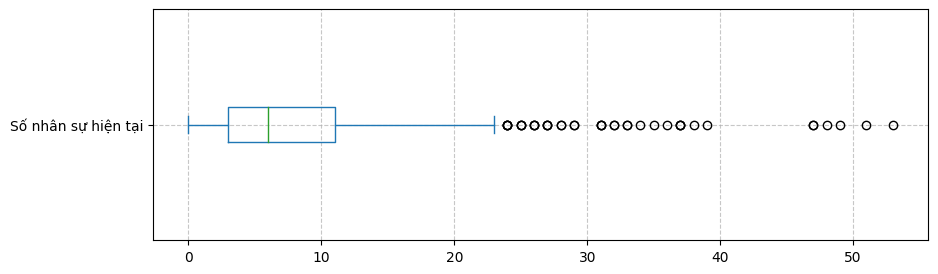

In [ ]:
plt.figure(figsize=(10, 3))
hub_breakdown['Số nhân sự hiện tại'].plot(kind='box', vert=False)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
hub_breakdown.sort_values(by='Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)', ascending=False).head(10)

hub_id  Số đơn trung bình mỗi ngày (Ngày thường)  \
3        15                                    153.36   
1        12                                     61.21   
55      205                                     40.64   
59      216                                     36.65   
30      130                                     33.39   
114     339                                     32.69   
259     831                                     31.93   
40      155                                     29.32   
483    1232                                     28.01   
537  103611                                     26.24   

     Tỷ lệ thành công lần đầu (Ngày thường)  \
3                                      0.00   
1                                      0.00   
55                                     0.00   
59                                     0.00   
30                                     0.00   
114                                    0.00   
259                                    0.00   
40                                     0.00   
483                                    0.00   
537                                    0.00   

     Số đơn trung bình mỗi ngày (Double Day)  \
3                                     441.38   
1                                     148.50   
55                                    120.00   
59                                    159.25   
30                                    125.50   
114                                    55.50   
259                                    98.88   
40                                    103.62   
483                                    95.88   
537                                   124.12   

     Tỷ lệ thành công lần đầu (Double Day)  Số nhân sự hiện tại  \
3                                     0.00                 6.00   
1                                     0.00                 1.00   
55                                    0.00                31.00   
59                                    0.00                26.00   
30                                    0.00                53.00   
114                                   0.00                13.00   
259                                   0.00                37.00   
40                                    0.00                29.00   
483                                   0.00                19.00   
537                                   0.00                23.00   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)  \
3                                                   262.25   
1                                                   104.66   
55                                                   69.50   
59                                                   62.67   
30                                                   57.10   
114                                                  55.91   
259                                                  54.59   
40                                                   50.14   
483                                                  47.90   
537                                                  44.87   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)  
3                                                  754.75  
1                                                  253.94  
55                                                 205.20  
59                                                 272.32  
30                                                 214.60  
114                                                 94.91  
259                                                169.08  
40                                                 177.20  
483                                                163.95  
537                                                212.25

sort theo số nhân sự

In [ ]:
sort_nhan_su = hub_breakdown.sort_values(by='Số nhân sự hiện tại', ascending=False).head(20)
sort_nhan_su

hub_id  Số đơn trung bình mỗi ngày (Ngày thường)  \
30      130                                     33.39   
69      236                                     22.57   
267     863                                     16.78   
27      116                                     14.68   
71      240                                      7.75   
28      120                                     10.49   
92      295                                     16.15   
46      171                                     11.10   
259     831                                     31.93   
804  104687                                      5.00   
79      259                                     19.47   
36      147                                     12.82   
29      125                                     13.93   
531  103322                                     14.28   
465    1209                                     16.54   
26      112                                     14.57   
262     843                                      6.48   
799  104533                                      8.79   
54      203                                      7.83   
266     859                                     15.87   

     Tỷ lệ thành công lần đầu (Ngày thường)  \
30                                     0.00   
69                                     0.00   
267                                    0.00   
27                                     0.00   
71                                     0.00   
28                                     0.00   
92                                     0.00   
46                                     0.00   
259                                    0.00   
804                                    0.00   
79                                     0.00   
36                                     0.00   
29                                     0.00   
531                                    0.00   
465                                    0.00   
26                                     0.00   
262                                    0.00   
799                                    0.00   
54                                     0.00   
266                                    0.00   

     Số đơn trung bình mỗi ngày (Double Day)  \
30                                    125.50   
69                                     99.25   
267                                    84.00   
27                                     57.38   
71                                     36.75   
28                                     41.75   
92                                     75.38   
46                                     47.25   
259                                    98.88   
804                                    18.38   
79                                     94.12   
36                                     49.38   
29                                     58.50   
531                                    53.00   
465                                    96.88   
26                                     67.88   
262                                    21.75   
799                                    29.25   
54                                     33.12   
266                                    60.75   

     Tỷ lệ thành công lần đầu (Double Day)  Số nhân sự hiện tại  \
30                                    0.00                53.00   
69                                    0.00                51.00   
267                                   0.00                49.00   
27                                    0.00                48.00   
71                                    0.00                47.00   
28                                    0.00                47.00   
92                                    0.00                39.00   
46                                    0.00                38.00   
259                                   0.00                37.00   
804                                   0.00                37.00   
79                                    0.00                37.00   
36    

In [ ]:
hub_breakdown_reset = sort_nhan_su.reset_index()
hub_breakdown_merged = hub.merge(hub_breakdown_reset, left_on='hub_id', right_on='pickup_hub_id')

map_center = [10.8231, 106.6297]
mymap = folium.Map(location=map_center, zoom_start=12)

for index, row in hub_breakdown_merged.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['Số đơn trung bình mỗi ngày (Ngày thường)'],  
        popup=(
            f"Hub ID: {row['pickup_hub_id']}<br>"
            f"Số đơn trung bình mỗi ngày (Ngày thường): {row['Số đơn trung bình mỗi ngày (Ngày thường)']}<br>"
            f"Số nhân sự hiện tại: {row['Số nhân sự hiện tại']}"
        ),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

display(mymap)


In [ ]:
sort_nhan_su_don = hub_breakdown[(hub_breakdown['Số đơn trung bình mỗi ngày (Ngày thường)']<=30)& (hub_breakdown['Số đơn trung bình mỗi ngày (Ngày thường)']>20)].sort_values(by='Số nhân sự hiện tại', ascending=False).head(20)
sort_nhan_su_don

hub_id  Số đơn trung bình mỗi ngày (Ngày thường)  \
69      236                                     22.57   
40      155                                     29.32   
62      222                                     25.86   
537  103611                                     26.24   
467    1211                                     24.51   
483    1232                                     28.01   
457    1197                                     20.36   
634  103903                                     21.42   
781  104347                                     22.29   

     Tỷ lệ thành công lần đầu (Ngày thường)  \
69                                     0.00   
40                                     0.00   
62                                     0.00   
537                                    0.00   
467                                    0.00   
483                                    0.00   
457                                    0.00   
634                                    0.00   
781                                    0.00   

     Số đơn trung bình mỗi ngày (Double Day)  \
69                                     99.25   
40                                    103.62   
62                                    134.25   
537                                   124.12   
467                                   122.00   
483                                    95.88   
457                                    66.38   
634                                    27.12   
781                                    72.12   

     Tỷ lệ thành công lần đầu (Double Day)  Số nhân sự hiện tại  \
69                                    0.00                51.00   
40                                    0.00                29.00   
62                                    0.00                29.00   
537                                   0.00                23.00   
467                                   0.00                20.00   
483                                   0.00                19.00   
457                                   0.00                18.00   
634                                   0.00                12.00   
781                                   0.00                12.00   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)  \
69                                                   38.59   
40                                                   50.14   
62                                                   44.22   
537                                                  44.87   
467                                                  41.91   
483                                                  47.90   
457                                                  34.81   
634                                                  36.63   
781                                                  38.11   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)  
69                                                 169.72  
40                                                 177.20  
62                                                 229.57  
537                                                212.25  
467                                                208.62  
483                                                163.95  
457                                                113.50  
634                                                 46.38  
781                                                123.33

In [ ]:
hub_breakdown_reset = sort_nhan_su_don.reset_index()
hub_breakdown_merged = hub.merge(hub_breakdown_reset, left_on='hub_id', right_on='pickup_hub_id')

map_center = [10.8231, 106.6297]
mymap = folium.Map(location=map_center, zoom_start=12)

for index, row in hub_breakdown_merged.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['Số đơn trung bình mỗi ngày (Ngày thường)'],  
        popup=(
            f"Hub ID: {row['pickup_hub_id']}<br>"
            f"Số đơn trung bình mỗi ngày (Ngày thường): {row['Số đơn trung bình mỗi ngày (Ngày thường)']}<br>"
            f"Số nhân sự hiện tại: {row['Số nhân sự hiện tại']}"
        ),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

display(mymap)

In [ ]:
perf_kem = hub_breakdown[hub_breakdown['Số đơn trung bình mỗi ngày (Ngày thường)']<=5]#.sort_values(by='Số nhân sự hiện tại', ascending=False).head(20)
perf_kem

hub_id  Số đơn trung bình mỗi ngày (Ngày thường)  \
0         1                                      0.11   
7        28                                      2.73   
8        32                                      4.64   
10       42                                      4.67   
11       45                                      1.60   
..      ...                                       ...   
802  104620                                      0.13   
803  104621                                      0.06   
804  104687                                      5.00   
805  104700                                      4.15   
806  104938                                      0.01   

     Tỷ lệ thành công lần đầu (Ngày thường)  \
0                                      0.00   
7                                      0.00   
8                                      0.00   
10                                     0.00   
11                                     0.00   
..                                      ...   
802                                    0.00   
803                                    0.00   
804                                    0.00   
805                                    0.00   
806                                    0.00   

     Số đơn trung bình mỗi ngày (Double Day)  \
0                                       0.25   
7                                       7.25   
8                                      18.50   
10                                     14.12   
11                                      4.62   
..                                       ...   
802                                      NaN   
803                                      NaN   
804                                    18.38   
805                                    13.88   
806                                      NaN   

     Tỷ lệ thành công lần đầu (Double Day)  Số nhân sự hiện tại  \
0                                      NaN                 1.00   
7                                     0.00                20.00   
8                                     0.00                10.00   
10                                    0.00                20.00   
11                                    0.00                10.00   
..                                     ...                  ...   
802                                    NaN                 0.00   
803                                    NaN                 0.00   
804                                   0.00                37.00   
805                                   0.00                16.00   
806                                    NaN                 0.00   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Ngày thường)  \
0                                                     0.19   
7                                                     4.67   
8                                                     7.93   
10                                                    7.98   
11                                                    2.74   
..                                                     ...   
802                                                   0.22   
803                                                   0.11   
804                                                   8.55   
805                                                   7.09   
806                                                   0.02   

     Số đơn trung bình mỗi ngày dự kiến 2023 (Double Day)  
0                                                    0.43  
7                                                   12.40  
8                                                   31.63  
10                                                  24.15  
11                                                   7.91  
..                                                    ...  
802                                                   NaN  
803                                                   NaN  
804                                                 31.42  
805                         

In [ ]:
hub_breakdown_reset = perf_kem.reset_index()
hub_breakdown_merged = hub.merge(hub_breakdown_reset, left_on='hub_id', right_on='pickup_hub_id')

map_center = [10.8231, 106.6297]
mymap = folium.Map(location=map_center, zoom_start=12)

for index, row in hub_breakdown_merged.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['Số đơn trung bình mỗi ngày (Ngày thường)'],  # Kích thước vòng tròn dựa trên số đơn hàng 
        popup=(
            f"Hub ID: {row['pickup_hub_id']}<br>"
            f"Số đơn trung bình mỗi ngày (Ngày thường): {row['Số đơn trung bình mỗi ngày (Ngày thường)']}<br>"
            f"Số nhân sự hiện tại: {row['Số nhân sự hiện tại']}"
        ),
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mymap)

display(mymap)

In [ ]:
order_milestones = om_cleaned.copy()
last_mile_report = lm.copy()

order_milestones['pickup_datetime'] = pd.to_datetime(order_milestones['pickup_datetime'])
order_milestones['delivery_success_datetime'] = pd.to_datetime(order_milestones['delivery_success_datetime'])

last_mile_report['dest_hub_datetime'] = pd.to_datetime(last_mile_report['dest_hub_datetime'])
last_mile_report['first_valid_delivery_attempt_datetime'] = pd.to_datetime(last_mile_report['first_valid_delivery_attempt_datetime'])

# Định nghĩa khoảng thời gian từ 8h sáng đến 8h tối
start_time = pd.to_datetime('08:00:00').time()
end_time = pd.to_datetime('20:00:00').time()

def filter_outside_working_hours(df, datetime_column):
    return df[(df[datetime_column].dt.time < start_time) | (df[datetime_column].dt.time > end_time)]

outside_hours_pickups = filter_outside_working_hours(order_milestones, 'pickup_datetime')
outside_hours_deliveries = filter_outside_working_hours(order_milestones, 'delivery_success_datetime')

outside_hours_dest_hub = filter_outside_working_hours(last_mile_report, 'dest_hub_datetime')
outside_hours_first_valid_delivery = filter_outside_working_hours(last_mile_report, 'first_valid_delivery_attempt_datetime')


result_pickups = outside_hours_pickups[['pickup_datetime', 'pickup_hub_id']]
result_deliveries = outside_hours_deliveries[['delivery_success_datetime', 'delivery_success_hub_id']]
result_dest_hub = outside_hours_dest_hub[['dest_hub_datetime', 'dest_hub_id']]
result_first_valid_delivery = outside_hours_first_valid_delivery[['first_valid_delivery_attempt_datetime', 'dest_hub_id']]


In [ ]:
order_milestones['pickup_datetime'] = pd.to_datetime(order_milestones['pickup_datetime'])
order_milestones['delivery_success_datetime'] = pd.to_datetime(order_milestones['delivery_success_datetime'])
last_mile_report['dest_hub_datetime'] = pd.to_datetime(last_mile_report['dest_hub_datetime'])
last_mile_report['first_valid_delivery_attempt_datetime'] = pd.to_datetime(last_mile_report['first_valid_delivery_attempt_datetime'])

# Định nghĩa khoảng thời gian từ 8h sáng đến 8h tối
start_time = pd.to_datetime('08:00:00').time()
end_time = pd.to_datetime('20:00:00').time()

def filter_outside_working_hours(df, datetime_column):
    return df[(df[datetime_column].dt.time < start_time) | (df[datetime_column].dt.time > end_time)]

outside_hours_pickups = filter_outside_working_hours(order_milestones, 'pickup_datetime')
outside_hours_deliveries = filter_outside_working_hours(order_milestones, 'delivery_success_datetime')

outside_hours_dest_hub = filter_outside_working_hours(last_mile_report, 'dest_hub_datetime')
outside_hours_first_valid_delivery = filter_outside_working_hours(last_mile_report, 'first_valid_delivery_attempt_datetime')

outside_hours_pickups['outside_working_hours'] = True
outside_hours_deliveries['outside_working_hours'] = True
outside_hours_dest_hub['outside_working_hours'] = True
outside_hours_first_valid_delivery['outside_working_hours'] = True


result_pickups = outside_hours_pickups[['pickup_datetime', 'pickup_hub_id', 'outside_working_hours']]
result_deliveries = outside_hours_deliveries[['delivery_success_datetime', 'delivery_success_hub_id', 'outside_working_hours']]
result_dest_hub = outside_hours_dest_hub[['dest_hub_datetime', 'dest_hub_id', 'outside_working_hours']]
result_first_valid_delivery = outside_hours_first_valid_delivery[['first_valid_delivery_attempt_datetime', 'dest_hub_id', 'outside_working_hours']]

result_combined = pd.concat([
    result_pickups.rename(columns={'pickup_datetime': 'datetime', 'pickup_hub_id': 'hub_id'}),
    result_deliveries.rename(columns={'delivery_success_datetime': 'datetime', 'delivery_success_hub_id': 'hub_id'}),
    result_dest_hub.rename(columns={'dest_hub_datetime': 'datetime', 'dest_hub_id': 'hub_id'}),
    result_first_valid_delivery.rename(columns={'first_valid_delivery_attempt_datetime': 'datetime', 'dest_hub_id': 'hub_id'})
], ignore_index=True)


result_combined.sort_values(by='datetime', inplace=True)

result_combined.to_csv('combined_results.csv', index=False)
result_combined


<ipython-input-39-741e2f4879fb>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outside_hours_pickups['outside_working_hours'] = True
<ipython-input-39-741e2f4879fb>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outside_hours_deliveries['outside_working_hours'] = True
<ipython-input-39-741e2f4879fb>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

datetime    hub_id  outside_working_hours
15     2022-01-04 20:25:51    361.00                   True
195948 2022-01-05 07:38:46   1011.00                   True
199981 2022-01-05 07:41:54    891.00                   True
199997 2022-01-05 07:50:02    291.00                   True
276089 2022-01-05 20:58:42    104.00                   True
...                    ...       ...                    ...
50510  2023-02-10 06:56:29 104063.00                   True
64679  2023-02-10 07:00:05    287.00                   True
63670  2023-02-10 07:52:04    138.00                   True
59823  2023-02-10 07:59:03    702.00                   True
61550  2023-02-22 07:15:47    321.00                   True

[278529 rows x 3 columns]

# 1.1: Dự báo số lượng

In [58]:
n_orders = om_cleaned.set_index('creation_datetime').resample('D').agg(order_count=('order_id', 'count'))

In [59]:
n_orders = om_cleaned.set_index('creation_datetime').resample('D').agg(order_count=('order_id', 'count'))
n_orders_2022 = n_orders.loc['2022']

n_orders_quarterly = n_orders_2022.resample('Q').sum()
average_orders_per_quarter = n_orders_quarterly['order_count'].mean()

C:\Users\PC\AppData\Local\Temp\ipykernel_3452\4025695517.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  n_orders_quarterly = n_orders_2022.resample('Q').sum()


In [60]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=n_orders.index, y=n_orders['order_count'], line=dict(color='blue'), name='Order Count')
)

fig.update_layout(
    title_text='Number of Orders Over Time',
    xaxis_title='Date',
    yaxis_title='Order Count',  
    template='plotly_white'
)

fig.show()

## ETS

In [61]:
train = n_orders[:'2022-09-30']
test = n_orders['2022-10-01':]

In [62]:
model = ExponentialSmoothing(
    train['order_count'],
    trend='add',
    seasonal='add',
    seasonal_periods=7,
    damped_trend=True,
    initialization_method='estimated'
).fit()

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [63]:
forecast = model.forecast(steps=len(test))

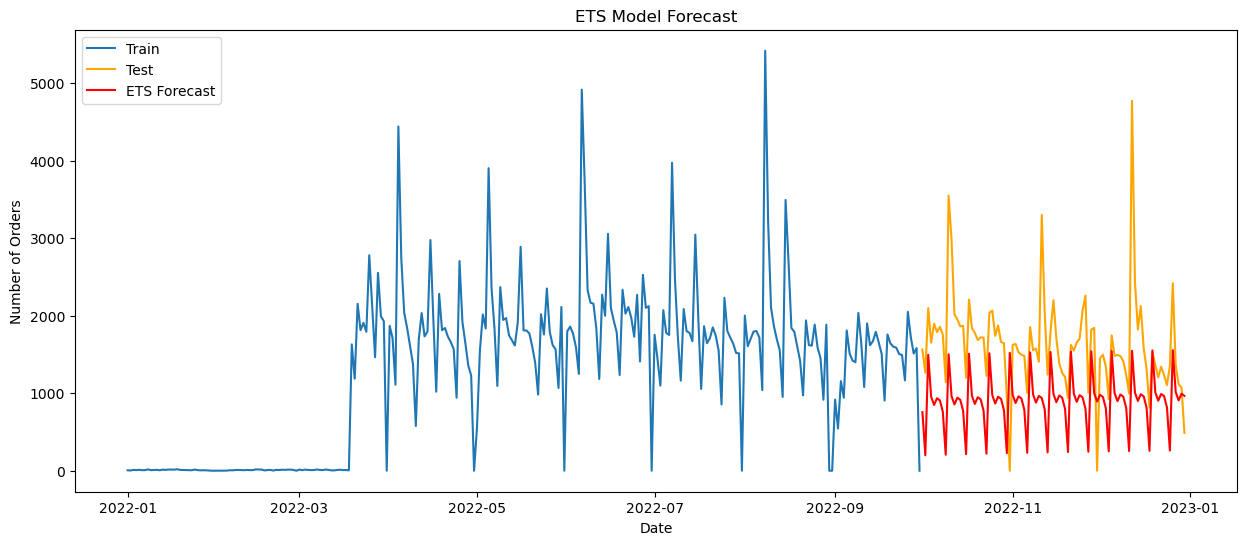

In [64]:
plt.figure(figsize=(15, 6))
plt.plot(train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(forecast, label='ETS Forecast', color='red')
plt.title('ETS Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

In [71]:
r_square = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = mean_absolute_percentage_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print("R-squared:", r_square)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: -1.1427348612782313
RMSE: 919.1213340254068
MAE: 784.913770788256


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Finetune

In [72]:
param_grid = {
    'trend': [None, 'add', 'mul'],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [7, 12],  # Weekly or monthly seasonality
    'damped_trend': [True, False],
    'use_boxcox': [True, False, 'log']
}


combinations = list(product(*param_grid.values()))

best_params = None
best_mse = float('inf')

for params in combinations:
    try:
        trend, seasonal, seasonal_periods, damped_trend, use_boxcox = params
        model = ExponentialSmoothing(
            train['order_count'],
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods,
            damped_trend=damped_trend,
            initialization_method='estimated'
        ).fit(use_boxcox=use_boxcox)

        # Forecast and evaluate
        forecast = model.forecast(len(test))
        mse = mean_squared_error(test['order_count'], forecast)

        if mse < best_mse:
            best_mse = mse
            best_params = params

    except Exception as e:
        print(f"Combination {params} failed with exception: {e}")

print(f"Best Parameters: {best_params}")
print(f"Best MSE: {best_mse}")

Combination (None, None, 7, True, True) failed with exception: Can only dampen the trend component
Combination (None, None, 7, True, False) failed with exception: Can only dampen the trend component
Combination (None, None, 7, True, 'log') failed with exception: Can only dampen the trend component
Combination (None, None, 7, False, True) failed with exception: use_boxcox was set at model initialization and cannot be changed
Combination (None, None, 7, False, False) failed with exception: use_boxcox was set at model initialization and cannot be changed
Combination (None, None, 7, False, 'log') failed with exception: use_boxcox was set at model initialization and cannot be changed
Combination (None, None, 12, True, True) failed with exception: Can only dampen the trend component
Combination (None, None, 12, True, False) failed with exception: Can only dampen the trend component
Combination (None, None, 12, True, 'log') failed with exception: Can only dampen the trend component
Combinatio

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so infe

## LSTM

In [73]:
train = n_orders[:'2022-09-30']
test = n_orders['2022-10-01':]

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

In [75]:
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the number of time steps (e.g., use the past 7 days to predict the next day)
time_step = 7
X_train, y_train = create_sequences(train_scaled, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)

In [ ]:
# Scale the test data
test_scaled = scaler.transform(test)

# Create test sequences
X_test, y_test = create_sequences(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


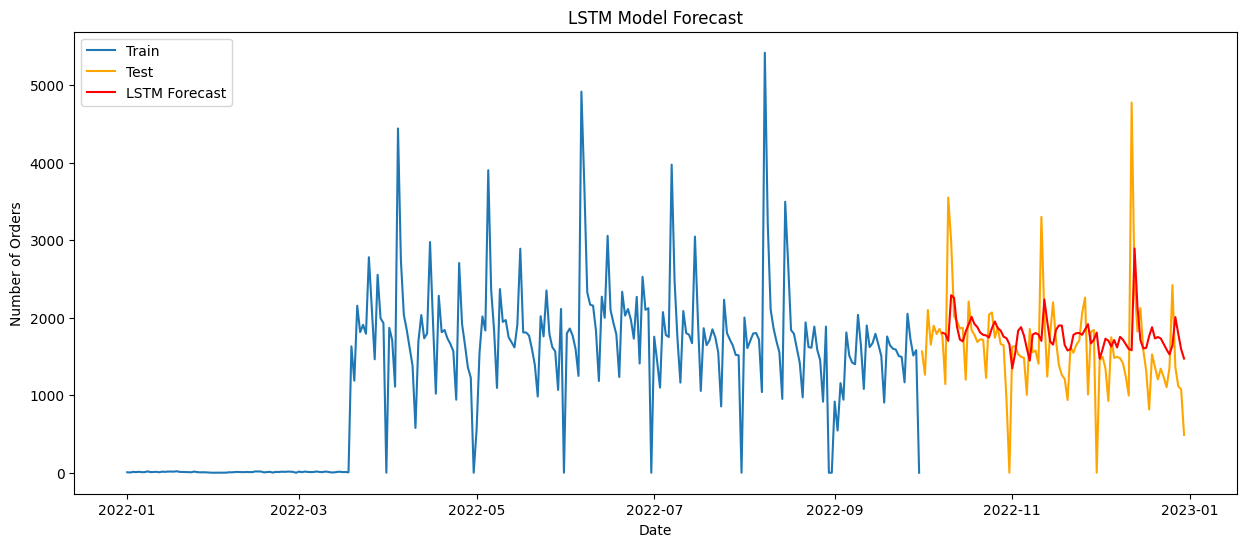

In [ ]:
adjusted_test_index = test.index[time_step:]

plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(adjusted_test_index, predictions, label='LSTM Forecast', color='red')
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()


In [ ]:
y_test_adjusted = y_test[:len(predictions)]

r_square = r2_score(y_test_adjusted, predictions)
rmse = mean_squared_error(y_test_adjusted, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test_adjusted, predictions)

print("R-squared:", r_square)
print("RMSE:", rmse)
print("MAPE:", mape)

R-squared: -221934478.99220434
RMSE: 1783.9088655698165
MAPE: 1.8584736788359853e+17


Finetune

In [ ]:
# Define a function to create the LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        return_sequences=True,
        input_shape=(time_step, 1)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(
        units=hp.Int('units2', min_value=32, max_value=256, step=32),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )
    return model

# Define the hyperparameter tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter settings to try
    executions_per_trial=1,
    directory='lstm_hyperparameter_tuning',
    project_name='order_forecast'
)

# Prepare data for LSTM input
train_scaled = scaler.fit_transform(train)
time_step = 7
X_train, y_train = create_sequences(train_scaled, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 00m 10s]
val_loss: 0.006608047988265753

Best val_loss So Far: 0.0059015778824687
Total elapsed time: 00h 02m 06s


In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the final model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.0592 - val_loss: 0.0291
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0275 - val_loss: 0.0071
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0166 - val_loss: 0.0072
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0150 - val_loss: 0.0079
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0183 - val_loss: 0.0068
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0154 - val_loss: 0.0070
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0163 - val_loss: 0.0074
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0173 - val_loss: 0.0066
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0185 - val_loss: 0.0062
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0173 - val_loss: 0.0075
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0149 - val_loss: 0.0067
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0158 - val_loss: 0.0063
Epoch 13/50

In [ ]:
test_scaled = scaler.transform(test)
X_test, y_test = create_sequences(test_scaled, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


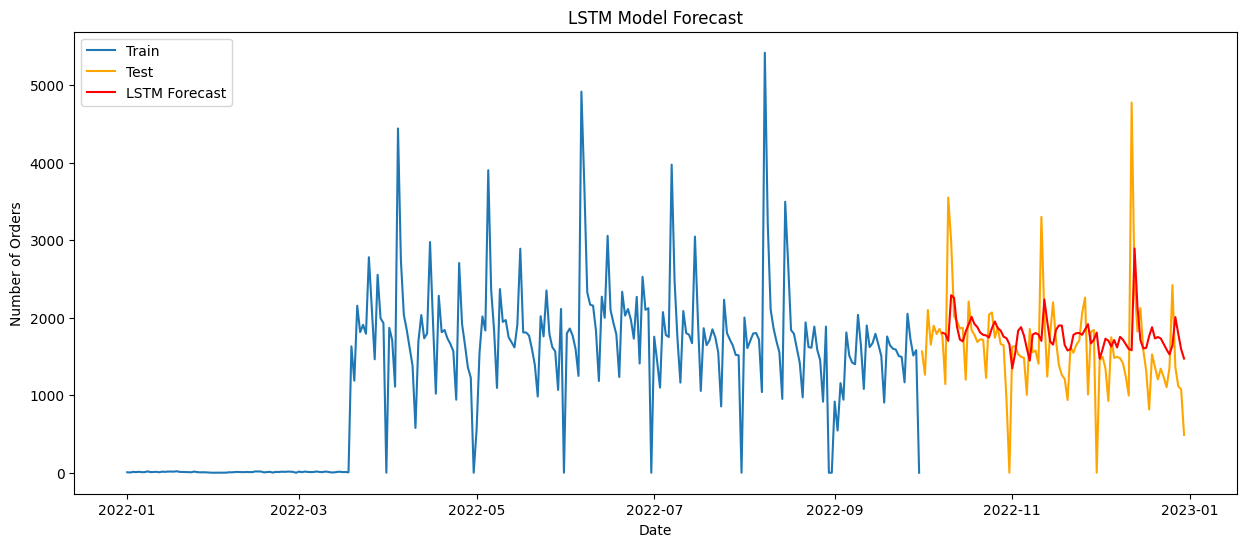

In [ ]:
adjusted_test_index = test.index[time_step:]

plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='orange')
plt.plot(adjusted_test_index, predictions, label='LSTM Forecast', color='red')
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

In [ ]:
y_test_adjusted = y_test[:len(predictions)]

r_square = r2_score(y_test_adjusted, predictions)
rmse = mean_squared_error(y_test_adjusted, predictions, squared=False)
mape = mean_absolute_percentage_error(y_test_adjusted, predictions)

print("R-squared:", r_square)
print("RMSE:", rmse)
print("MAPE:", mape)

R-squared: -221934478.99220434
RMSE: 1783.9088655698165
MAPE: 1.8584736788359853e+17


## Prophet

In [82]:
holidays = calendar[calendar['comments'].notna()][['date', 'comments']]
holidays.rename(columns={'date': 'ds', 'comments': 'holiday'}, inplace=True)

In [ ]:
double_days = []
for month in range(1, 13):  # Từ tháng 1 đến tháng 12
    double_days.append(pd.Timestamp(year=2022, month=month, day=month))

for month in range(1, 4):  # Từ tháng 1 đến tháng 3
    if month == 1:
        double_days.append(pd.Timestamp(year=2023, month=month, day=1))  # New Year's Day
    else:
        double_days.append(pd.Timestamp(year=2023, month=month, day=month))

lunar_new_year_eve = pd.Timestamp(year=2023, month=1, day=21)  # 21 tháng 1, 2023
lunar_new_year = pd.Timestamp(year=2023, month=1, day=22)  # 22 tháng 1, 2023
lunar_new_year2 = pd.Timestamp(year=2023, month=1, day=23)
lunar_new_year3 = pd.Timestamp(year=2023, month=1, day=24)
lunar_new_year4 = pd.Timestamp(year=2023, month=1, day=25)
lunar_new_year5 = pd.Timestamp(year=2023, month=1, day=26)

double_days.append(lunar_new_year_eve)
double_days.append(lunar_new_year)
double_days.append(lunar_new_year2)
double_days.append(lunar_new_year3)
double_days.append(lunar_new_year4)
double_days.append(lunar_new_year5)

double_days_df = pd.DataFrame({
    'holiday': ['Double Day' if ds == pd.Timestamp('2023-01-01') else
                'Lunar New Year Eve' if ds == lunar_new_year_eve else
                'Lunar New Year' if ds == lunar_new_year else
                'Lunar New Year' if ds == lunar_new_year2 else
                'Lunar New Year' if ds == lunar_new_year3 else
                'Lunar New Year' if ds == lunar_new_year4 else
                'Lunar New Year' if ds == lunar_new_year5 else
                'Double Day' for ds in double_days],
    'ds': double_days
})

holidays = pd.concat([holidays, double_days_df], ignore_index=True)

In [84]:
new_holidays = pd.DataFrame({
    'ds': [
        '2023-04-29', '2023-04-30', '2023-05-01', '2023-09-01', '2023-09-02', '2023-09-04'
    ],
    'holiday': [
        'Hung King Temple Festival (in lieu)', 'Reunification Day', 'Labour Day', 'National Day (in lieu)', 'National Day', 'National Day (in lieu)'
    ]
})

# Convert 'ds' to datetime
holidays['ds'] = pd.to_datetime(holidays['ds'])
new_holidays['ds'] = pd.to_datetime(new_holidays['ds'])

# Concatenate the new holidays with the existing ones
holidays = pd.concat([holidays, new_holidays], ignore_index=True)

double_days_2023 = pd.DataFrame({
    'ds': [
        '2023-04-04', '2023-05-05', '2023-06-06', '2023-07-07', '2023-08-08',
        '2023-09-09', '2023-10-10', '2023-11-11', '2023-12-12'
    ],
    'holiday': [
        'Double Day', 'Double Day', 'Double Day', 'Double Day', 'Double Day',
        'Double Day', 'Double Day', 'Double Day', 'Double Day'
    ]
})

holidays['ds'] = pd.to_datetime(holidays['ds'])
double_days_2023['ds'] = pd.to_datetime(double_days_2023['ds'])

holidays = pd.concat([holidays, double_days_2023], ignore_index=True)

In [ ]:
covid = calendar[['date']].copy()
covid['date'] = pd.to_datetime(covid['date'])

covid['is_covid'] = covid['date'].apply(lambda x: 1 if pd.Timestamp('2022-01-01') <= x <= pd.Timestamp('2022-03-31') else 0)
covid.rename(columns={'date': 'ds', 'is_covid': 'covid'}, inplace=True)
covid

ds  covid
0   2022-01-01      1
1   2022-01-02      1
2   2022-01-03      1
3   2022-01-04      1
4   2022-01-05      1
..         ...    ...
360 2022-12-27      0
361 2022-12-28      0
362 2022-12-29      0
363 2022-12-30      0
364 2022-12-31      0

[365 rows x 2 columns]

In [87]:
om_cleaned.columns

Index(['order_id', 'creation_datetime', 'cod_value_sgd', 'granular_status',
       'rts_flag', 'order_type', 'shipper_id', 'shipper_reference_number',
       'delivery_type', 'pickup_hub_id', 'pickup_datetime', 'pickup_attempts',
       'pickup_driver_id', 'description', 'from_city', 'to_city',
       'dest_province_code', 'delivery_success_hub_id',
       'delivery_success_datetime', 'rts_trigger_datetime',
       'delivery_attempts', 'first_valid_delivery_attempt_datetime',
       'first_valid_delivery_attempt_status',
       'second_valid_delivery_attempt_datetime',
       'second_valid_delivery_attempt_status',
       'third_valid_delivery_attempt_datetime',
       'third_valid_delivery_attempt_status',
       'last_valid_delivery_attempt_datetime',
       'last_valid_delivery_attempt_status', 'first_failure_reason',
       'second_failure_reason', 'third_failure_reason', 'last_failure_reason',
       'delivery_driver_id', 'items', 'weight', 'width', 'height', 'length',
       'par

In [86]:
pricing

Weight (kg)  delivery_type   price
0                        ≤ 0.5  Intracity (1)   15000
1                          ≤ 2  Intracity (1)   16000
2                          ≤ 3  Intracity (1)   22000
3                          ≤ 4  Intracity (1)   22000
4                          ≤ 5  Intracity (1)   22000
..                         ...            ...     ...
75                        ≤ 19  Interzone (4)  190000
76                        ≤ 20  Interzone (4)  200000
77  Mỗi 1kg tiếp theo đến 30kg  Interzone (4)   10000
78  Mỗi 1kg tiếp theo đến 50kg  Interzone (4)    8500
79                   Trên 50kg  Interzone (4)    7000

[80 rows x 3 columns]

In [ ]:
order_data.index = pd.to_datetime(order_data.index, errors='coerce')

order_data['creation_date'] = order_data.index.date

distinct_orders = order_data.groupby('creation_date')['order_id'].nunique()

df_forecast = distinct_orders.reset_index().rename(columns={'creation_date': 'Date'})

Date  order_id
0    2022-01-01         6
1    2022-01-02         3
2    2022-01-03        11
3    2022-01-04         8
4    2022-01-05        12
..          ...       ...
343  2022-12-26      2420
344  2022-12-27      1363
345  2022-12-28      1117
346  2022-12-29      1074
347  2022-12-30       487

[348 rows x 2 columns]

In [ ]:
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])
df_forecast.rename(columns={'Date': 'ds', 'order_id': 'y'}, inplace=True)
df_forecast = pd.merge(df_forecast, covid, on='ds', how='left')
df_forecast.head()

ds   y  covid
0 2022-01-01   6      1
1 2022-01-02   3      1
2 2022-01-03  11      1
3 2022-01-04   8      1
4 2022-01-05  12      1

In [ ]:
model = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale= 1.0,
    holidays_prior_scale= 1.0,
    interval_width=0.95,
    daily_seasonality=False,        # Tắt mùa vụ hàng ngày nếu không cần thiết
    weekly_seasonality=True
)

In [ ]:
model.add_regressor('covid')

In [ ]:
train = df_forecast[(df_forecast['ds'] >= '2022-01-01') & (df_forecast['ds'] <= '2022-11-30')]
test = df_forecast[(df_forecast['ds'] >= '2022-12-01') & (df_forecast['ds'] <= '2022-12-31')]

In [ ]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/8yx1q9c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/egxq5vot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40629', 'data', 'file=/tmp/tmpnnh5lb7j/8yx1q9c1.json', 'init=/tmp/tmpnnh5lb7j/egxq5vot.json', 'output', 'file=/tmp/tmpnnh5lb7j/prophet_model1p_fhy_n/prophet_model-20240908081936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test), freq='D')
future = pd.merge(future, covid, on='ds', how='left')
forecast = model.predict(future)

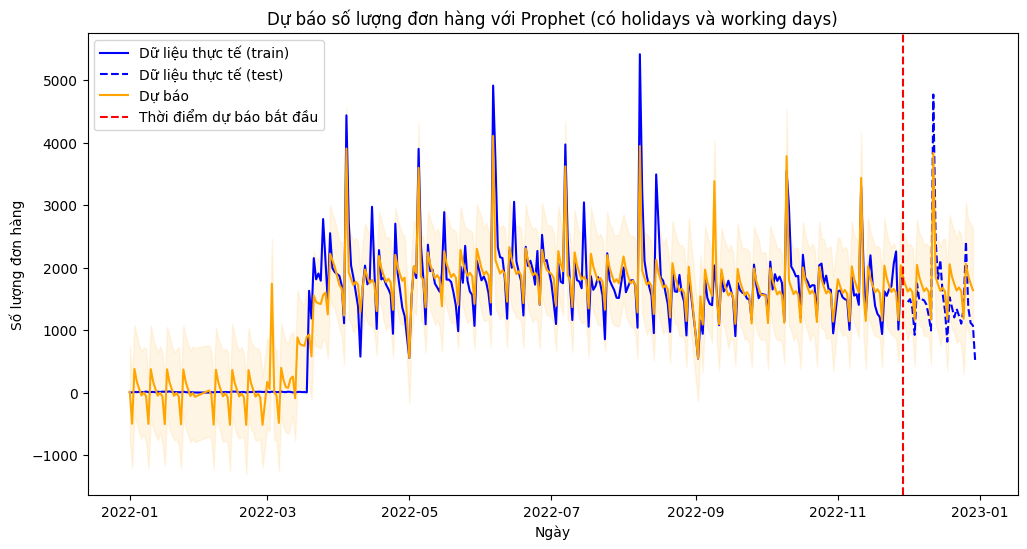

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], color='blue', label='Dữ liệu thực tế (train)', linestyle='-')
plt.plot(test['ds'], test['y'], color='blue', label='Dữ liệu thực tế (test)', linestyle='--')

plt.plot(forecast['ds'], forecast['yhat'], color='orange', linestyle='-', label='Dự báo')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.1)
plt.axvline(x=train['ds'].max(), color='red', linestyle='--', label='Thời điểm dự báo bắt đầu')

plt.title('Dự báo số lượng đơn hàng với Prophet (có holidays và working days)')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.legend()

plt.show()

In [ ]:
r_square = r2_score(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
mape = mean_absolute_percentage_error(test, forecast)
print("R-squared:", r_square)
print("RMSE:", rmse)
print("MAPE:", mape)

In [ ]:
threshold = actual.mean()
actual_class = (actual > threshold).astype(int)
predicted_class = (predicted > threshold).astype(int)

accuracy = accuracy_score(actual_class, predicted_class)
f1 = f1_score(actual_class, predicted_class)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1-score: {f1:.4f}')

Accuracy: 0.9066
F1-score: 0.9264


In [ ]:
full_dates = pd.date_range(start='2022-01-01', end='2022-12-31')
df_full = pd.DataFrame({'ds': full_dates}).merge(df_forecast, on='ds', how='left')

In [ ]:
df_full['month'] = df_full['ds'].dt.month

df_full['y'] = df_full['y'].bfill().ffill()
df_full['covid'] = df_full['covid'].bfill().ffill()
df_full.drop(columns='month', inplace=True)

In [ ]:
model = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale= 1.0,
    interval_width=0.8,
    daily_seasonality=False,        # Tắt mùa vụ hàng ngày nếu không cần thiết
    weekly_seasonality=True
    # yearly_seasonality=True
)

In [ ]:
model.add_regressor("covid")

In [ ]:
model.fit(df_full)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/dq3j3qan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/swp73klx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14788', 'data', 'file=/tmp/tmpnnh5lb7j/dq3j3qan.json', 'init=/tmp/tmpnnh5lb7j/swp73klx.json', 'output', 'file=/tmp/tmpnnh5lb7j/prophet_model6ew8065r/prophet_model-20240908082046.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=31)
future = pd.merge(future, covid, on='ds', how='left')
future['covid'] = future['covid'].fillna(0)
forecast = model.predict(future)

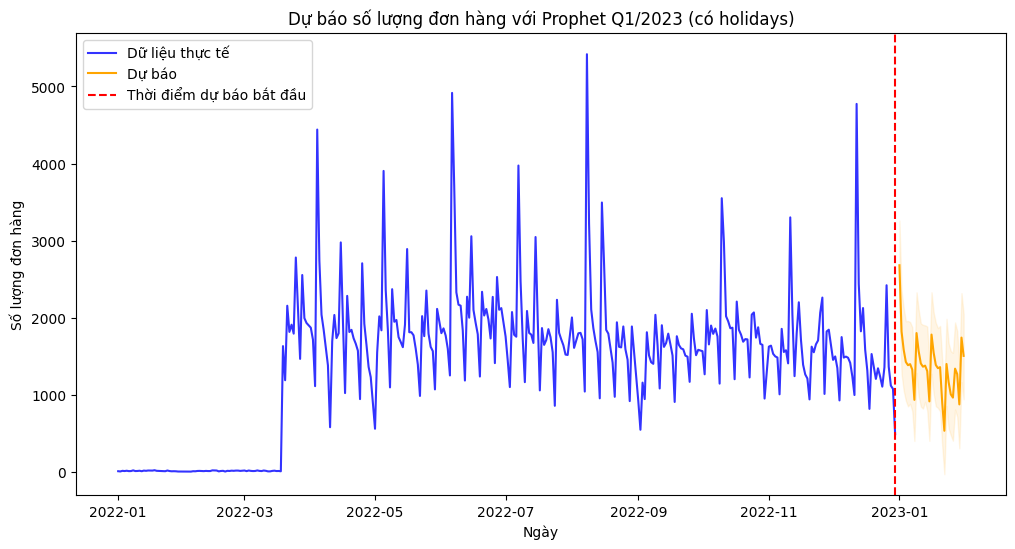

In [ ]:
forecast_2023 = forecast[forecast['ds'].dt.year == 2023]

plt.figure(figsize=(12, 6))

# Vẽ dữ liệu thực tế
plt.plot(df_forecast['ds'], df_forecast['y'], color='blue', alpha=0.8, label='Dữ liệu thực tế', linestyle='-')

# Vẽ dữ liệu dự báo và vùng tin cậy chỉ cho năm 2023
plt.plot(forecast_2023['ds'], forecast_2023['yhat'], color='orange', label='Dự báo')
plt.fill_between(forecast_2023['ds'], forecast_2023['yhat_lower'], forecast_2023['yhat_upper'], color='orange', alpha=0.1)

# Đánh dấu thời điểm dự báo bắt đầu
plt.axvline(x=df_forecast['ds'].max(), color='red', linestyle='--', label='Thời điểm dự báo bắt đầu')

# Thêm nhãn và tiêu đề
plt.title('Dự báo số lượng đơn hàng với Prophet Q1/2023 (có holidays)')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đơn hàng')
plt.legend()

# Hiển thị biểu đồ
plt.show()

In [ ]:
forecast_2023 = forecast[forecast['ds'].dt.year == 2023]
forecast_2023
forecast_yhat = forecast_2023[['ds', 'yhat']]

print(forecast_yhat)

            ds    yhat
365 2023-01-01 2679.44
366 2023-01-02 1818.88
367 2023-01-03 1581.67
368 2023-01-04 1424.25
369 2023-01-05 1382.41
370 2023-01-06 1396.10
371 2023-01-07 1325.29
372 2023-01-08  932.09
373 2023-01-09 1799.28
374 2023-01-10 1562.07
375 2023-01-11 1404.65
376 2023-01-12 1362.81
377 2023-01-13 1376.49
378 2023-01-14 1305.69
379 2023-01-15  912.48
380 2023-01-16 1779.67
381 2023-01-17 1542.47
382 2023-01-18 1385.05
383 2023-01-19 1343.20
384 2023-01-20 1356.89
385 2023-01-21  893.21
386 2023-01-22  530.77
387 2023-01-23 1397.96
388 2023-01-24 1160.76
389 2023-01-25 1003.34
390 2023-01-26  961.49
391 2023-01-27 1337.29
392 2023-01-28 1266.48
393 2023-01-29  873.28
394 2023-01-30 1740.47
395 2023-01-31 1503.26


In [ ]:
if 'covid' not in future_feb.columns:
    future_feb['covid'] = 0

# Proceed with the forecast
forecast_feb = m_extended.predict(future_feb)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df_full['ds'], df_full['y'], color='blue', alpha=0.8, label='Actual Data', linestyle='-')

# Determine the start date for February 2023 forecast
start_date_feb = df_full['ds'].max() + pd.Timedelta(days=1)

# Plot the forecast for February 2023
plt.plot(forecast_feb[forecast_feb['ds'] >= start_date_feb]['ds'],
         forecast_feb[forecast_feb['ds'] >= start_date_feb]['yhat'],
         color='orange', label='Forecast')
plt.fill_between(forecast_feb[forecast_feb['ds'] >= start_date_feb]['ds'],
                 forecast_feb[forecast_feb['ds'] >= start_date_feb]['yhat_lower'],
                 forecast_feb[forecast_feb['ds'] >= start_date_feb]['yhat_upper'],
                 color='orange', alpha=0.1)

# Mark the point where the forecast starts
plt.axvline(x=df_full['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Add labels and title
plt.title('Prophet Forecast for Order Volume in February 2023')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.legend()

# Show the plot
plt.show()

In [ ]:
forecast_2023 = forecast_feb[forecast_feb['ds'].dt.year == 2023]
forecast_2023
# Lọc chỉ lấy cột 'ds' và 'yhat'
forecast_yhat = forecast_2023[['ds', 'yhat']]

In [ ]:
# Lọc chỉ lấy cột 'ds', 'yhat', 'yhat_lower', và 'yhat_upper'
forecast_yhat = forecast_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Chuyển đổi cột 'ds' thành định dạng datetime
forecast_yhat['ds'] = pd.to_datetime(forecast_yhat['ds'])

# Trích xuất năm và tháng từ cột 'ds'
forecast_yhat['YearMonth'] = forecast_yhat['ds'].dt.to_period('M')

# Nhóm theo 'YearMonth' và tính toán trung bình cho 'yhat', 'yhat_lower', và 'yhat_upper'
monthly_volume = forecast_yhat.groupby('YearMonth').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).reset_index()

# Đổi tên cột cho rõ ràng
monthly_volume.columns = ['Month', 'Average Volume', 'Lower Bound', 'Upper Bound']

# Chuyển 'Month' về định dạng chuỗi nếu cần
monthly_volume['Month'] = monthly_volume['Month'].astype(str)

monthly_volume

In [ ]:
forecast_2023 = forecast_2023[['ds', 'yhat']]

In [ ]:
# Rename the column in forecast_2023
forecast_2023.rename(columns={'yhat': 'y'}, inplace=True)

# Combine the original data with the forecast data
df_extended = pd.concat([df_full, forecast_2023], ignore_index=True)

# Fill missing values in the 'covid' column with 0
df_extended['covid'] = df_extended['covid'].fillna(0)

# Retrain the model with the extended data
m_extended = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=0.8,
    interval_width=0.8,
    daily_seasonality=False,  # Disable daily seasonality if not needed
    weekly_seasonality=True
)

m_extended.add_regressor("covid")

# Fit the model
m_extended.fit(df_extended)

# Forecast for March 2023
future_mar = m_extended.make_future_dataframe(periods=31)
future_mar = pd.merge(future_mar, covid, on='ds', how='left')
future_mar['covid'] = future_mar['covid'].fillna(0)
forecast_mar = m_extended.predict(future_mar)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df_full['ds'], df_full['y'], color='blue', alpha=0.8, label='Actual Data', linestyle='-')

# Determine the start date for March 2023 forecast
start_date_mar = df_full['ds'].max() + pd.Timedelta(days=1)

# Plot the forecast for March 2023 and the confidence intervals
plt.plot(forecast_mar[forecast_mar['ds'] >= start_date_mar]['ds'],
         forecast_mar[forecast_mar['ds'] >= start_date_mar]['yhat'],
         color='orange', label='Forecast')
plt.fill_between(forecast_mar[forecast_mar['ds'] >= start_date_mar]['ds'],
                 forecast_mar[forecast_mar['ds'] >= start_date_mar]['yhat_lower'],
                 forecast_mar[forecast_mar['ds'] >= start_date_mar]['yhat_upper'],
                 color='orange', alpha=0.1)

# Mark the point where the forecast starts
plt.axvline(x=df_full['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Add labels and title
plt.title('Prophet Forecast for Order Volume in March 2023')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.legend()

# Show the plot
plt.show()

In [ ]:
forecast_2023 = forecast_mar[forecast_mar['ds'].dt.year == 2023]
forecast_2023
# Lọc chỉ lấy cột 'ds' và 'yhat'
forecast_yhat = forecast_2023[['ds', 'yhat']]

In [ ]:
# Lọc chỉ lấy cột 'ds', 'yhat', 'yhat_lower', và 'yhat_upper'
forecast_yhat = forecast_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Chuyển đổi cột 'ds' thành định dạng datetime
forecast_yhat['ds'] = pd.to_datetime(forecast_yhat['ds'])

# Trích xuất năm và tháng từ cột 'ds'
forecast_yhat['YearMonth'] = forecast_yhat['ds'].dt.to_period('M')

# Nhóm theo 'YearMonth' và tính toán trung bình cho 'yhat', 'yhat_lower', và 'yhat_upper'
monthly_volume = forecast_yhat.groupby('YearMonth').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).reset_index()

# Đổi tên cột cho rõ ràng
monthly_volume.columns = ['Month', 'Average Volume', 'Lower Bound', 'Upper Bound']

# Chuyển 'Month' về định dạng chuỗi nếu cần
monthly_volume['Month'] = monthly_volume['Month'].astype(str)

print(monthly_volume)

In [ ]:
forecast_2023.rename(columns={'yhat': 'y'}, inplace=True)

# Add forecast data to the original dataset
df_extended = pd.concat([df_full, forecast_2023])

# Fill missing 'covid' values with 0 in df_extended
df_extended['covid'] = df_extended['covid'].fillna(0)

# Retrain the model with the extended dataset including the 'covid' regressor
m_extended = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=0.8,
    interval_width=0.8,
    daily_seasonality=False,  # Disable daily seasonality if not needed
    weekly_seasonality=True
)
m_extended.add_regressor('covid')
m_extended.fit(df_extended)

# Forecast for February 2023
future_arp = m_extended.make_future_dataframe(periods=30)
# Add the 'covid' regressor to the future dataframe
future_arp = pd.merge(future_arp, covid, on='ds', how='left')
future_arp['covid'] = future_arp['covid'].fillna(0)
forecast_arp = m_extended.predict(future_arp)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df_full['ds'], df_full['y'], color='blue', alpha=0.8, label='Actual Data', linestyle='-')

# Determine the start date for the February 2023 forecast
start_date_arp = df_full['ds'].max() + pd.Timedelta(days=1)

# Plot forecast data and confidence intervals for February 2023
plt.plot(forecast_arp[forecast_arp['ds'] >= start_date_arp]['ds'],
         forecast_arp[forecast_arp['ds'] >= start_date_arp]['yhat'],
         color='orange', label='Forecast')
plt.fill_between(forecast_arp[forecast_arp['ds'] >= start_date_arp]['ds'],
                 forecast_arp[forecast_arp['ds'] >= start_date_arp]['yhat_lower'],
                 forecast_arp[forecast_arp['ds'] >= start_date_arp]['yhat_upper'],
                 color='orange', alpha=0.1)

# Mark the start of the forecast period
plt.axvline(x=df_full['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Add labels and title
plt.title('Prophet Forecast for Order Volume in February 2023')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.legend()

# Show the plot
plt.show()

In [ ]:
forecast_2023 = forecast_arp[forecast_arp['ds'].dt.year == 2023]
forecast_2023
# Lọc chỉ lấy cột 'ds' và 'yhat'
forecast_yhat = forecast_2023[['ds', 'yhat']]

# Hiển thị kết quả
print(forecast_yhat)

In [ ]:
# Lọc chỉ lấy cột 'ds', 'yhat', 'yhat_lower', và 'yhat_upper'
forecast_yhat = forecast_2023[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Chuyển đổi cột 'ds' thành định dạng datetime
forecast_yhat['ds'] = pd.to_datetime(forecast_yhat['ds'])

# Trích xuất năm và tháng từ cột 'ds'
forecast_yhat['YearMonth'] = forecast_yhat['ds'].dt.to_period('M')

# Nhóm theo 'YearMonth' và tính toán trung bình cho 'yhat', 'yhat_lower', và 'yhat_upper'
monthly_volume = forecast_yhat.groupby('YearMonth').agg({
    'yhat': 'sum',
    'yhat_lower': 'sum',
    'yhat_upper': 'sum'
}).reset_index()

# Đổi tên cột cho rõ ràng
monthly_volume.columns = ['Month', 'Average Volume', 'Lower Bound', 'Upper Bound']

# Chuyển 'Month' về định dạng chuỗi nếu cần
monthly_volume['Month'] = monthly_volume['Month'].astype(str)

print(monthly_volume)

In [ ]:
forecast_2023 = forecast_2023[['ds', 'yhat']]

In [ ]:
forecast_2023.rename(columns={'yhat': 'y'}, inplace=True)

# Add forecast data to the original dataset
df_extended = pd.concat([df_full, forecast_2023])

# Fill missing values for the 'covid' regressor
df_extended['covid'] = df_extended['covid'].fillna(0)

# Train the model with the extended dataset
m_extended = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=0.1,
    interval_width=0.8,
    daily_seasonality=False,  # Disable daily seasonality if not needed
    weekly_seasonality=True
)
m_extended.add_regressor('covid')
m_extended.fit(df_extended)

# Forecast for May 2023
future_may = m_extended.make_future_dataframe(periods=31)
# Add the 'covid' regressor to the future dataframe
future_may = pd.merge(future_may, covid, on='ds', how='left')
future_may['covid'] = future_may['covid'].fillna(0)
forecast_may = m_extended.predict(future_may)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(df_full['ds'], df_full['y'], color='blue', alpha=0.8, label='Actual Data', linestyle='-')

# Determine the start date for the May 2023 forecast
start_date_may = df_full['ds'].max() + pd.Timedelta(days=1)

# Plot forecast data and confidence intervals for May 2023
plt.plot(forecast_may[forecast_may['ds'] >= start_date_may]['ds'],
         forecast_may[forecast_may['ds'] >= start_date_may]['yhat'],
         color='orange', label='Forecast')
plt.fill_between(forecast_may[forecast_may['ds'] >= start_date_may]['ds'],
                 forecast_may[forecast_may['ds'] >= start_date_may]['yhat_lower'],
                 forecast_may[forecast_may['ds'] >= start_date_may]['yhat_upper'],
                 color='orange', alpha=0.1)

# Mark the start of the forecast period
plt.axvline(x=df_full['ds'].max(), color='red', linestyle='--', label='Forecast Start')

# Add labels and title
plt.title('Prophet Forecast for Order Volume in May 2023')
plt.xlabel('Date')
plt.ylabel('Order Volume')
plt.legend()

# Show the plot
plt.show()

# 1.2. Dự báo doanh thu

In [ ]:
order_data = pd.read_csv('/content/drive/MyDrive/om_cleaned_price.csv')
order_data.info()

<ipython-input-150-b59deefee907>:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  order_data = pd.read_csv('/content/drive/MyDrive/om_cleaned_price.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494261 entries, 0 to 494260
Data columns (total 49 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Unnamed: 0                              494261 non-null  int64  
 1   order_id                                494261 non-null  int64  
 2   creation_datetime                       494259 non-null  object 
 3   cod_value_sgd                           404024 non-null  float64
 4   granular_status                         494261 non-null  object 
 5   rts_flag                                494261 non-null  int64  
 6   order_type                              494261 non-null  object 
 7   shipper_id                              494261 non-null  int64  
 8   shipper_reference_number                378021 non-null  object 
 9   delivery_type                           494261 non-null  object 
 10  pickup_hub_id                           4942

In [ ]:
order_data['creation_datetime'] = pd.to_datetime(order_data['creation_datetime'], errors='coerce')

order_data.set_index('creation_datetime', inplace=True)

revenue = order_data.resample('D').agg(rev=('price', 'sum'))

In [ ]:
total_price = order_data['price'].sum()
total_price

## Prophet

In [ ]:
holidays = calendar[calendar['comments'].notna()][['date', 'comments']]
holidays.rename(columns={'date': 'ds', 'comments': 'holiday'}, inplace=True)

In [ ]:
double_days = []
for month in range(1, 13):  
    double_days.append(pd.Timestamp(year=2022, month=month, day=month))

for month in range(1, 4): 
    if month == 1:
        double_days.append(pd.Timestamp(year=2023, month=month, day=1))  # New Year's Day
    else:
        double_days.append(pd.Timestamp(year=2023, month=month, day=month))

# Thêm Lunar New Year Eve và Lunar New Year
lunar_new_year_eve = pd.Timestamp(year=2023, month=1, day=21)  # 21 tháng 1, 2023
lunar_new_year = pd.Timestamp(year=2023, month=1, day=22)  # 22 tháng 1, 2023
lunar_new_year2 = pd.Timestamp(year=2023, month=1, day=23)
lunar_new_year3 = pd.Timestamp(year=2023, month=1, day=24)
lunar_new_year4 = pd.Timestamp(year=2023, month=1, day=25)
lunar_new_year5 = pd.Timestamp(year=2023, month=1, day=26)

double_days.append(lunar_new_year_eve)
double_days.append(lunar_new_year)
double_days.append(lunar_new_year2)
double_days.append(lunar_new_year3)
double_days.append(lunar_new_year4)
double_days.append(lunar_new_year5)

double_days_df = pd.DataFrame({
    'holiday': ['Double Day' if ds == pd.Timestamp('2023-01-01') else
                'Lunar New Year Eve' if ds == lunar_new_year_eve else
                'Lunar New Year' if ds == lunar_new_year else
                'Lunar New Year' if ds == lunar_new_year2 else
                'Lunar New Year' if ds == lunar_new_year3 else
                'Lunar New Year' if ds == lunar_new_year4 else
                'Lunar New Year' if ds == lunar_new_year5 else
                'Double Day' for ds in double_days],
    'ds': double_days
})

holidays = pd.concat([holidays, double_days_df], ignore_index=True)

In [ ]:
new_holidays = pd.DataFrame({
    'ds': [
        '2023-04-29', '2023-04-30', '2023-05-01', '2023-09-01', '2023-09-02', '2023-09-04'
    ],
    'holiday': [
        'Hung King Temple Festival (in lieu)', 'Reunification Day', 'Labour Day', 'National Day (in lieu)', 'National Day', 'National Day (in lieu)'
    ]
})

# Convert 'ds' to datetime
holidays['ds'] = pd.to_datetime(holidays['ds'])
new_holidays['ds'] = pd.to_datetime(new_holidays['ds'])

# Concatenate the new holidays with the existing ones
holidays = pd.concat([holidays, new_holidays], ignore_index=True)

double_days_2023 = pd.DataFrame({
    'ds': [
        '2023-04-04', '2023-05-05', '2023-06-06', '2023-07-07', '2023-08-08',
        '2023-09-09', '2023-10-10', '2023-11-11', '2023-12-12'
    ],
    'holiday': [
        'Double Day', 'Double Day', 'Double Day', 'Double Day', 'Double Day',
        'Double Day', 'Double Day', 'Double Day', 'Double Day'
    ]
})

holidays['ds'] = pd.to_datetime(holidays['ds'])
double_days_2023['ds'] = pd.to_datetime(double_days_2023['ds'])

# Concatenate the new Double Days with the existing holidays
holidays = pd.concat([holidays, double_days_2023], ignore_index=True)

# Display the updated holidays DataFrame
print(holidays)

           ds                              holiday
0  2022-01-01                       New Year's Day
1  2022-01-31                   Lunar New Year Eve
2  2022-02-01                       Lunar New Year
3  2022-02-02                       Lunar New Year
4  2022-02-03                       Lunar New Year
5  2022-02-04                       Lunar New Year
6  2022-02-05                       Lunar New Year
7  2022-04-11  Hung King Temple Festival (in lieu)
8  2022-04-30                    Reunification Day
9  2022-05-01                           Labour Day
10 2022-05-02          Reunification Day (in lieu)
11 2022-09-01               National Day (in lieu)
12 2022-09-02                         National Day
13 2022-01-01                           Double Day
14 2022-02-02                           Double Day
15 2022-03-03                           Double Day
16 2022-04-04                           Double Day
17 2022-05-05                           Double Day
18 2022-06-06                  

In [ ]:
covid = calendar[['date']].copy()
covid['date'] = pd.to_datetime(covid['date'])

covid['is_covid'] = covid['date'].apply(lambda x: 1 if pd.Timestamp('2022-01-01') <= x <= pd.Timestamp('2022-03-31') else 0)
covid.rename(columns={'date': 'ds', 'is_covid': 'covid'}, inplace=True)
covid

ds  covid
0   2022-01-01      1
1   2022-01-02      1
2   2022-01-03      1
3   2022-01-04      1
4   2022-01-05      1
..         ...    ...
360 2022-12-27      0
361 2022-12-28      0
362 2022-12-29      0
363 2022-12-30      0
364 2022-12-31      0

[365 rows x 2 columns]

In [ ]:
revenue.reset_index(inplace=True)
revenue.rename(columns={'creation_datetime': 'ds', 'rev': 'y'}, inplace=True)
revenue = pd.merge(revenue, covid, on='ds', how='left')
revenue

ds           y  covid
0   2022-01-01    92000.00      1
1   2022-01-02    46000.00      1
2   2022-01-03   231000.00      1
3   2022-01-04   129000.00      1
4   2022-01-05   197000.00      1
..         ...         ...    ...
359 2022-12-26 52364500.24      0
360 2022-12-27 29980150.38      0
361 2022-12-28 23732058.95      0
362 2022-12-29 20561421.44      0
363 2022-12-30  9275760.00      0

[364 rows x 3 columns]

In [ ]:
model = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.5,
    seasonality_prior_scale= 1.0,
    holidays_prior_scale= 1.0,
    interval_width=0.95,
    daily_seasonality=False,        # Tắt mùa vụ hàng ngày nếu không cần thiết
    weekly_seasonality=True
)

In [ ]:
train = revenue[(revenue['ds'] >= '2022-01-01') & (revenue['ds'] <= '2022-11-30')]
test = revenue[(revenue['ds'] >= '2022-12-01') & (revenue['ds'] <= '2022-12-31')]

In [ ]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/sltpgo_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnnh5lb7j/ktozcgfx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86106', 'data', 'file=/tmp/tmpnnh5lb7j/sltpgo_9.json', 'init=/tmp/tmpnnh5lb7j/ktozcgfx.json', 'output', 'file=/tmp/tmpnnh5lb7j/prophet_modelwftye_7r/prophet_model-20240908131011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:10:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:10:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(test), freq='D')
future = pd.merge(future, covid, on='ds', how='left')
forecast = model.predict(future)

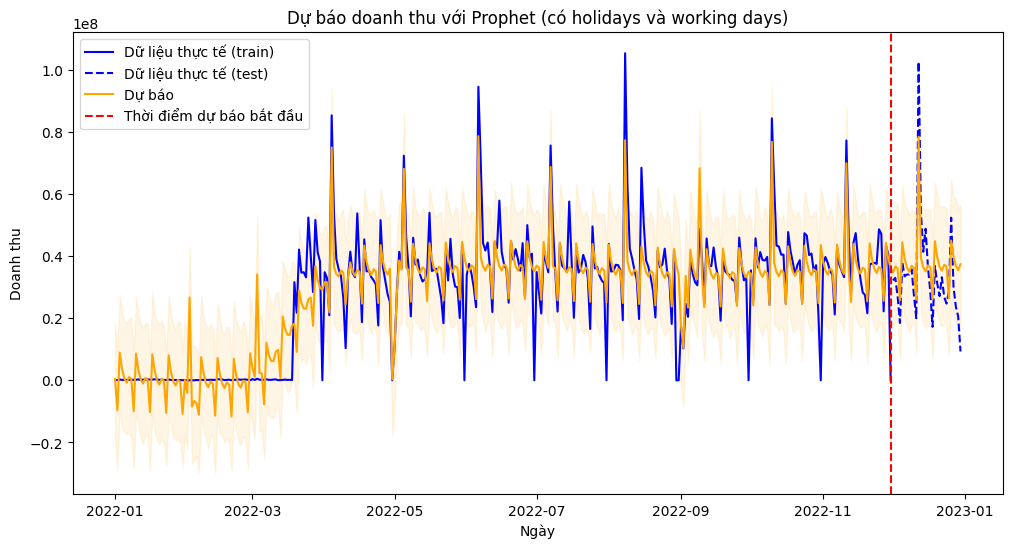

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(train['ds'], train['y'], color='blue', label='Dữ liệu thực tế (train)', linestyle='-')

plt.plot(test['ds'], test['y'], color='blue', label='Dữ liệu thực tế (test)', linestyle='--')

plt.plot(forecast['ds'], forecast['yhat'], color='orange', linestyle='-', label='Dự báo')

plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.1)

plt.axvline(x=train['ds'].max(), color='red', linestyle='--', label='Thời điểm dự báo bắt đầu')

plt.title('Dự báo doanh thu với Prophet (có holidays và working days)')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()

plt.show()

In [ ]:
actual = pd.concat([train['y'], test['y']]).values
predicted = forecast['yhat'][:len(actual)].values  


mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
r2 = r2_score(actual, predicted)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R²: {r2:.4f}')

Mean Absolute Error (MAE): 6086179.62
Mean Squared Error (MSE): 90939094156429.45
Root Mean Squared Error (RMSE): 9536199.15
R²: 0.7569


In [ ]:
full_dates = pd.date_range(start='2022-01-01', end='2022-12-31')
df_full = pd.DataFrame({'ds': full_dates}).merge(revenue, on='ds', how='left')

In [ ]:
df_full['month'] = df_full['ds'].dt.month


df_full['y'] = df_full['y'].bfill().ffill()
df_full['covid'] = df_full['covid'].bfill().ffill()

df_full.drop(columns='month', inplace=True)

In [ ]:
model = Prophet(
    holidays=holidays,
    seasonality_mode='additive',
    changepoint_prior_scale=0.2,
    seasonality_prior_scale= 1.0,
    interval_width=0.8,
    daily_seasonality=False,        # Tắt mùa vụ hàng ngày nếu không cần thiết
    weekly_seasonality=True
    # yearly_seasonality=True
)

In [ ]:
model.add_regressor("covid")

In [ ]:
model.fit(df_full)

In [ ]:
future = model.make_future_dataframe(periods=31)
future = pd.merge(future, covid, on='ds', how='left')
future['covid'] = future['covid'].fillna(0)
forecast = model.predict(future)

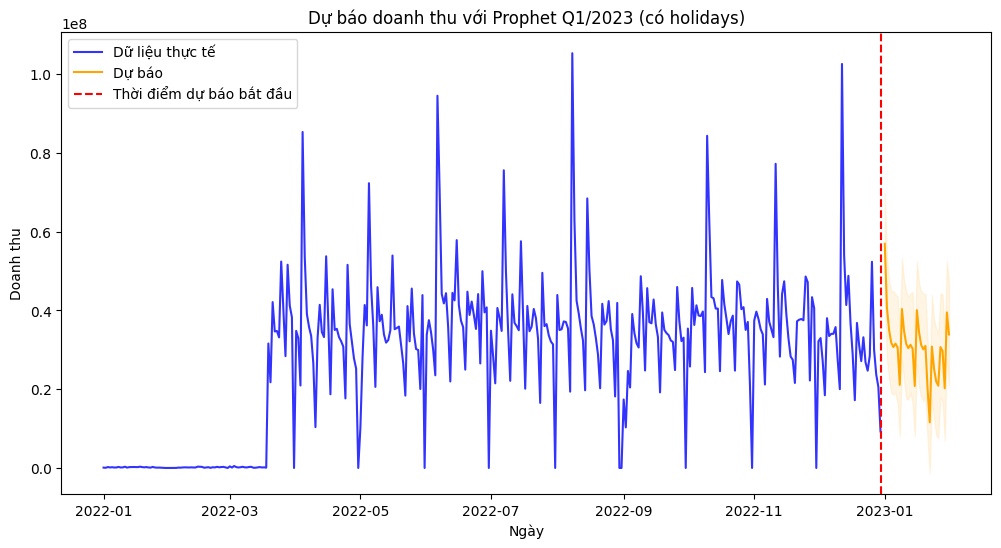

In [ ]:
forecast_2023 = forecast[forecast['ds'].dt.year == 2023]

plt.figure(figsize=(12, 6))

# Vẽ dữ liệu thực tế
plt.plot(revenue['ds'], revenue['y'], color='blue', alpha=0.8, label='Dữ liệu thực tế', linestyle='-')

# Vẽ dữ liệu dự báo và vùng tin cậy chỉ cho năm 2023
plt.plot(forecast_2023['ds'], forecast_2023['yhat'], color='orange', label='Dự báo')
plt.fill_between(forecast_2023['ds'], forecast_2023['yhat_lower'], forecast_2023['yhat_upper'], color='orange', alpha=0.1)

# Đánh dấu thời điểm dự báo bắt đầu
plt.axvline(x=revenue['ds'].max(), color='red', linestyle='--', label='Thời điểm dự báo bắt đầu')

# Thêm nhãn và tiêu đề
plt.title('Dự báo doanh thu với Prophet Q1/2023 (có holidays)')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')
plt.legend()

# Hiển thị biểu đồ
plt.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=revenue.index, y=revenue['rev'], line=dict(color='purple'), name='Revenue')
)

# Update layout with titles and theme
fig.update_layout(
    title_text='Revenue Over Time',
    xaxis_title='Date',
    yaxis_title='Revenue',  # Primary y-axis title
    template='plotly_white'
)

fig.show()

## Hồi quy

In [ ]:
order_data = pd.merge(order_data, hub[['hub_id', 'region', 'facility_type']],
                      left_on='pickup_hub_id', right_on='hub_id', how='left')
order_data = pd.merge(order_data, hub[['hub_id', 'region', 'facility_type']],
                      left_on='delivery_success_hub_id', right_on='hub_id', how='left', suffixes=('_pickup', '_delivery'))

# Thêm thông tin từ bảng Shippers Enriched (nối dựa trên shipper_id)
order_data = pd.merge(order_data, shipper[['shipper_id', 'industry']],
                      on='shipper_id', how='left')

In [ ]:
order_data['creation_datetime'] = pd.to_datetime(order_data['creation_datetime'], errors='coerce')
order_data['creation_date'] = order_data['creation_datetime'].dt.date


calendar['date'] = pd.to_datetime(calendar['date']).dt.date

calendar_features = calendar[['date', 'working_day', 'comments']]

order_data = pd.merge(order_data, calendar_features,
                      left_on='creation_date', right_on='date',
                      how='left')

order_data['double_day'] = order_data['comments'].apply(lambda x: 1 if 'double' in str(x).lower() else 0)

In [ ]:
features = ['cod_value_sgd', 'granular_status', 'delivery_attempts', 'weight', 'parcel_size', 'last_valid_delivery_attempt_status', 'pu_region', 'deli_region', 'order_type', 'facility_type_delivery', 'double_day', 'working_day']
target = 'price'

In [ ]:
categorical_cols = ['granular_status', 'parcel_size', 'pu_region', 'deli_region', 'order_type', 'facility_type_delivery','last_valid_delivery_attempt_status']
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(), categorical_cols)], remainder='passthrough')


scaler = StandardScaler()

In [ ]:
order_data['month'] = pd.to_datetime(order_data['creation_date']).dt.month
train_data = order_data[order_data['month'] <= 9]
test_data = order_data[order_data['month'] > 9]



X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]


X_train = X_train.dropna()
y_train = y_train[X_train.index]  
X_test = X_test.dropna()
y_test = y_test[X_test.index]  


In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

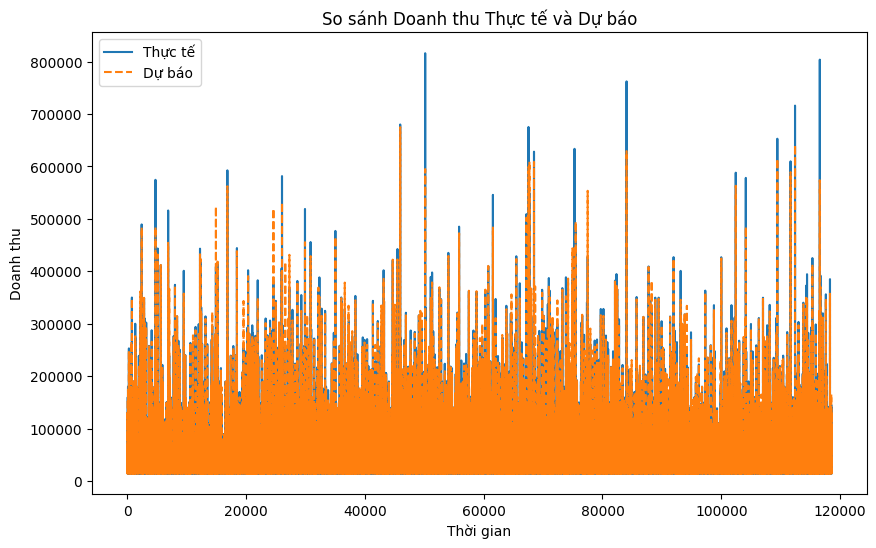

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Thực tế')
plt.plot(y_pred, label='Dự báo', linestyle='--')
plt.legend()
plt.title('So sánh Doanh thu Thực tế và Dự báo')
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R2 Score: {r2}')

RMSE: 2647.461086037087
MAPE: 0.003453875615112879
R2 Score: 0.9887340803524439
